In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
# from dynamic_routing_analysis import decoding_utils , plot_utils
# import dynamic_routing_analysis as dra
# import npc_lims

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
# %matplotlib inline
%matplotlib widget

In [ ]:
# results_path=r's3://aind-scratch-data/dynamic-routing/decoding/results/binsize_1.5_sec_0/'
# session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.265.csv"

# results_path = "s3://aind-scratch-data/dynamic-routing/decoding/results/time_mod_keep_units_consistent_0/" # 20 units; all sessions
# session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.268.csv"

# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_w_shifts_min_10_units_500ms_0/" #10 units; all sessions
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.272.csv"

# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_blockwise_crossval_20251215_182620/" # 1 repeat, all units

# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_blockwise_crossval_w_repeats_and_linear_shift_20251215_214910/" #blockwise crossval with repeats and linear shift (example)
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_5fold_crossval_w_repeats_and_linear_shift_20251215_220056/" #5fold crossval with repeats and linear shift (example)

# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_blockwise_crossval_w_repeats_and_linear_shift_0/"

# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_blockwise_crossval_w_repeats_and_linear_shift_20251216_231119/" #single templeton experiment, saved labels
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_5fold_crossval_w_repeats_and_linear_shift_20251216_233541/" #same single templeton experiment, 5fold
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_blockwise_crossval_w_repeats_and_linear_shift_strict_unit_drift_0/" #strict drift criterion, all sessions

# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_5fold_crossval_w_repeats_and_linear_shift_strict_drift_20251217_163538/" #actually blockwise, templeton
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_5fold_crossval_w_repeats_and_linear_shift_strict_drift_20251217_170836/" #5fold, templeton
results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_blockwise_crossval_w_repeats_and_linear_shift_strict_drift_20_units_0/"


session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    pl.col('is_good_behavior').eq(True),
    pl.col('is_engaged').eq(True),
    )['session_id'].to_list()
    )

all_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    # pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [67]:
# import npc_lims
# trials=pd.read_parquet(
#             npc_lims.get_cache_path('trials','742903_2024-10-22',version='any')
#         )

# performance=pd.read_parquet(
#             npc_lims.get_cache_path('performance','742903_2024-10-22',version='any')
#         )

In [68]:
# trials.columns

In [39]:
# performance.columns
# performance['signed_cross_modal_dprime']
# performance['cross_modal_dprime']
# trials.columns

In [ ]:
# session_table.to_pandas().query('project=="DynamicRouting" and is_good_behavior and is_production')['session_id'].unique()

In [75]:
#define grouping columns
grouping_cols = {
    'session_id',
    'structure',
    'bin_center',
    'electrode_group_names',
    'unit_subsample_size',
    'unit_criteria',
    'labels',
}

#toggle combine_multi_probe_rec
combine_multi_probe_rec = True

if combine_multi_probe_rec:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().gt(1) | pl.col('is_sole_recording').eq(True)
else:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().eq(1) | pl.col('is_sole_recording').eq(True)


In [73]:
# int('742903_2024-10-22'.replace('_','').replace('-',''))

In [60]:
### make separate query to include repeats - specify session
sel_session='742903_2024-10-22' #the golden session
# sel_session='670180_2023-07-27' #a templeton session
predict_proba_with_repeats_single_session = (
    pl.scan_parquet(results_path)
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),     
    )
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials'),
        pl.col('session_id').eq(sel_session),
    )#.drop('unit_ids') 
    # .sort('session_id', descending=True)
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/units.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            .group_by('session_id','structure')
            .agg(
                pl.col('unit_id').len().alias('total_n_units')
            )
        ),
        on=['session_id','structure'],
        how='inner',
    )
    .with_columns(
        # pl.int_ranges(0, pl.col('predict_proba').list.len()).alias('trial_index')
        pl.col('trial_indices').alias('trial_index')
    )
    .drop('shift_idx', 'is_all_trials', 'electrode_group_names', 'unit_criteria', 'is_sole_recording')
    .explode('predict_proba', 'trial_index')
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/trials.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            .select('session_id', 'trial_index', 'is_vis_rewarded', 'stim_name', 'is_response', 'trial_index_in_block', 'block_index')
        ),
        on=['session_id','trial_index'],
        how='inner',
    ) 
    .group_by('session_id', 'structure', 'unit_subsample_size', 'repeat_idx', 'bin_center', 'unit_ids', 'labels')
    .agg(
        pl.col('balanced_accuracy_test', 'total_n_units').first(),
        pl.col('predict_proba', 'trial_index', 'is_vis_rewarded', 'stim_name', 'is_response', 'trial_index_in_block', 'block_index'),
    )
    .sort('session_id','structure', 'unit_subsample_size', 'repeat_idx', 'bin_center')
    # .group_by('session_id','structure')
    .collect()
)

In [15]:
# pl.scan_parquet(results_path).columns

In [61]:
predict_proba_with_repeats_single_session

session_id,structure,unit_subsample_size,repeat_idx,bin_center,unit_ids,labels,balanced_accuracy_test,total_n_units,predict_proba,trial_index,is_vis_rewarded,stim_name,is_response,trial_index_in_block,block_index
str,str,u16,u16,f64,list[str],list[i64],f64,u32,list[f64],list[u16],list[bool],list[str],list[bool],list[f64],list[i64]
"""742903_2024-10-22""","""ACAd""",20,0,-0.25,"[""742903_2024-10-22_A-100"", ""742903_2024-10-22_A-103"", … ""742903_2024-10-22_A-96""]","[0, 0, … 1]",0.6724,134,"[0.793265, 0.570849, … 0.509992]","[0, 1, … 537]","[false, false, … true]","[""sound1"", ""sound1"", … ""sound1""]","[true, true, … true]","[0.0, 1.0, … 88.0]","[0, 0, … 5]"
"""742903_2024-10-22""","""ACAd""",20,1,-0.25,"[""742903_2024-10-22_A-100"", ""742903_2024-10-22_A-103"", … ""742903_2024-10-22_A-99""]","[0, 0, … 1]",0.710353,134,"[0.543716, 0.282815, … 0.511276]","[0, 1, … 537]","[false, false, … true]","[""sound1"", ""sound1"", … ""sound1""]","[true, true, … true]","[0.0, 1.0, … 88.0]","[0, 0, … 5]"
"""742903_2024-10-22""","""ACAd""",20,2,-0.25,"[""742903_2024-10-22_A-103"", ""742903_2024-10-22_A-108"", … ""742903_2024-10-22_A-99""]","[0, 0, … 1]",0.678018,134,"[0.687138, 0.308404, … 0.839945]","[0, 1, … 537]","[false, false, … true]","[""sound1"", ""sound1"", … ""sound1""]","[true, true, … true]","[0.0, 1.0, … 88.0]","[0, 0, … 5]"
"""742903_2024-10-22""","""ACAd""",20,3,-0.25,"[""742903_2024-10-22_A-104"", ""742903_2024-10-22_A-106"", … ""742903_2024-10-22_A-99""]","[0, 0, … 1]",0.566896,134,"[0.598127, 0.407918, … 0.560896]","[0, 1, … 537]","[false, false, … true]","[""sound1"", ""sound1"", … ""sound1""]","[true, true, … true]","[0.0, 1.0, … 88.0]","[0, 0, … 5]"
"""742903_2024-10-22""","""ACAd""",20,4,-0.25,"[""742903_2024-10-22_A-104"", ""742903_2024-10-22_A-106"", … ""742903_2024-10-22_A-96""]","[0, 0, … 1]",0.548182,134,"[0.329073, 0.514287, … 0.706977]","[0, 1, … 537]","[false, false, … true]","[""sound1"", ""sound1"", … ""sound1""]","[true, true, … true]","[0.0, 1.0, … 88.0]","[0, 0, … 5]"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""742903_2024-10-22""","""TTd""",20,20,-0.25,"[""742903_2024-10-22_E-1"", ""742903_2024-10-22_E-1006"", … ""742903_2024-10-22_E-85""]","[0, 0, … 1]",0.495799,240,"[0.341135, 0.404909, … 0.41842]","[0, 1, … 537]","[false, false, … true]","[""sound1"", ""sound1"", … ""sound1""]","[true, true, … true]","[0.0, 1.0, … 88.0]","[0, 0, … 5]"
"""742903_2024-10-22""","""TTd""",20,21,-0.25,"[""742903_2024-10-22_E-10"", ""742903_2024-10-22_E-12"", … ""742903_2024-10-22_E-994""]","[0, 0, … 1]",0.487868,240,"[0.39509, 0.395033, … 0.524832]","[0, 1, … 537]","[false, false, … true]","[""sound1"", ""sound1"", … ""sound1""]","[true, true, … true]","[0.0, 1.0, … 88.0]","[0, 0, … 5]"
"""742903_2024-10-22""","""TTd""",20,22,-0.25,"[""742903_2024-10-22_E-10"", ""742903_2024-10-22_E-1213"", … ""742903_2024-10-22_F-0""]","[0, 0, … 1]",0.431781,240,"[0.467379, 0.652707, … 0.474721]","[0, 1, … 537]","[false, false, … true]","[""sound1"", ""sound1"", … ""sound1""]","[true, true, … true]","[0.0, 1.0, … 88.0]","[0, 0, … 5]"


In [62]:
predict_proba_single_session_pd=predict_proba_with_repeats_single_session.to_pandas()

In [63]:
predict_proba_single_session_pd['structure'].unique()

array(['ACAd', 'ACAv', 'CP', 'GU', 'ILA', 'LSr', 'MOs', 'ORBl', 'ORBm',
       'ORBvl', 'PL', 'SSp', 'SSs', 'TTd'], dtype=object)

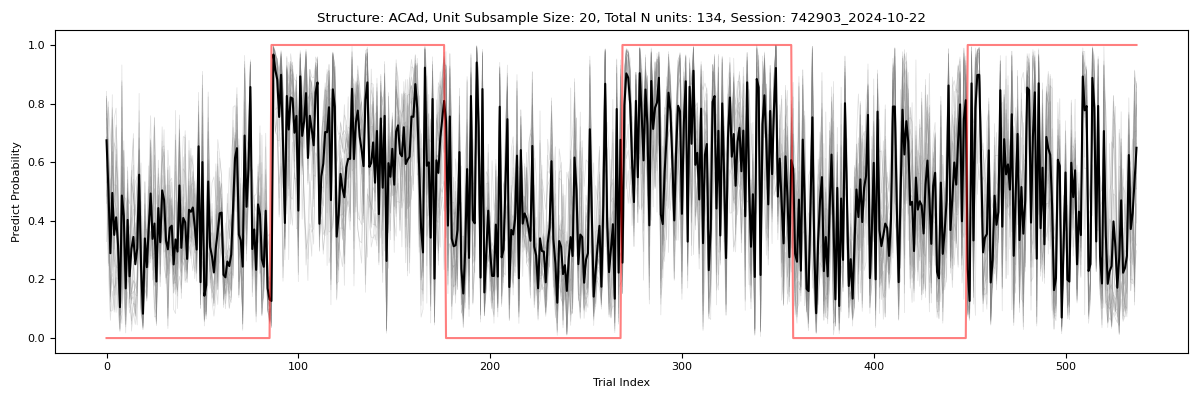

In [67]:
# show individual repeats, averages over repeats, etc.
sel_bin_center=-0.25
sel_structure='ACAd'
sel_unit_subsample=20
if sel_unit_subsample is None or sel_unit_subsample == 'all':
    structure_predict_proba=predict_proba_single_session_pd.query('structure==@sel_structure and unit_subsample_size.isna() and bin_center==@sel_bin_center')
else:
    structure_predict_proba=predict_proba_single_session_pd.query('structure==@sel_structure and unit_subsample_size==@sel_unit_subsample and bin_center==@sel_bin_center')

trial_index=structure_predict_proba['trial_index'].iloc[0]
total_n_units=structure_predict_proba['total_n_units'].iloc[0]

fig,ax=plt.subplots(figsize=(12,4))
ax.plot(trial_index, np.vstack(structure_predict_proba['predict_proba'].values).T, color='grey', alpha=0.25, linewidth=0.5)
ax.plot(trial_index, np.mean(np.vstack(structure_predict_proba['predict_proba'].values),0), color='black')
ax.plot(trial_index, structure_predict_proba['labels'].values[0], color='red', alpha=0.5, label='true label')
ax.set_xlabel('Trial Index')
ax.set_ylabel('Predict Probability')
ax.set_title(f'Structure: {sel_structure}, Unit Subsample Size: {sel_unit_subsample}, Total N units: {total_n_units}, Session: {sel_session}')
fig.tight_layout()


In [83]:
structure_predict_proba['is_vis_rewarded'].iloc[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [ ]:
#correlation across repeats

# np.corrcoef(np.vstack(structure_predict_proba['predict_proba'].values))

In [ ]:
# set(r1['unit_ids'].values[0])

# r1['predict_proba'].values[0]

In [ ]:
# find how many shared units in each pair of repeats
from itertools import combinations

def get_shared_units(repeat1, repeat2):
    units1 = set(repeat1['unit_ids'].values[0])
    units2 = set(repeat2['unit_ids'].values[0])
    return len(units1.intersection(units2))


repeat_pairs = list(combinations(structure_predict_proba['repeat_idx'].unique(), 2))
shared_units_counts = []
for repeat1, repeat2 in repeat_pairs:
    r1 = structure_predict_proba.query('repeat_idx==@repeat1')
    r2 = structure_predict_proba.query('repeat_idx==@repeat2')

    rval,pval = stats.pearsonr(r1['predict_proba'].values[0], r2['predict_proba'].values[0])
    
    shared_units = get_shared_units(r1, r2)
    shared_units_counts.append((repeat1, repeat2, shared_units, rval))

shared_units_df = pd.DataFrame(shared_units_counts, columns=['repeat1', 'repeat2', 'shared_units', 'r'])
# shared_units_df = shared_units_df.sort_values(by='shared_units', ascending=False)
shared_units_df

In [ ]:
fig,ax = plt.subplots(figsize=(6,4))
ax.scatter(shared_units_df['shared_units'], shared_units_df['r'], alpha=0.5)

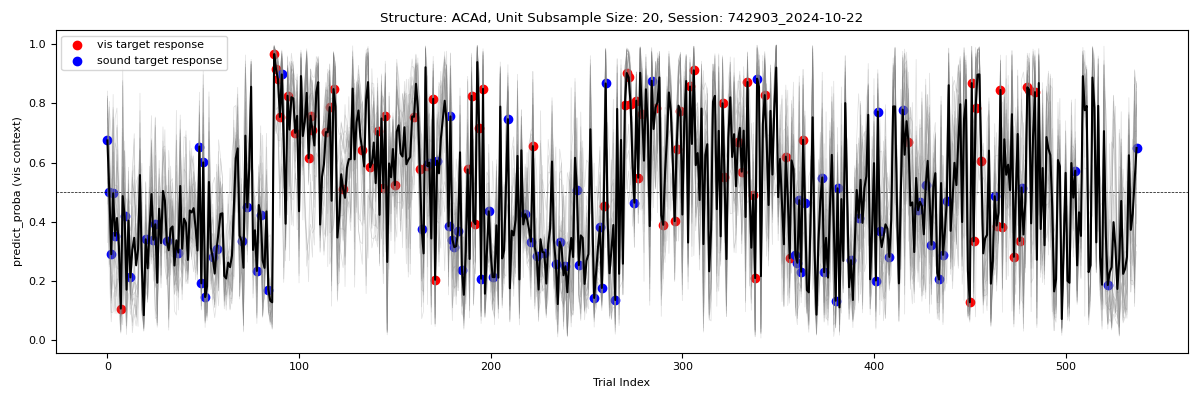

In [68]:
# show responses to different stimuli on the same plot
sel_bin_center=-0.25
sel_structure='ACAd'
sel_unit_subsample=20
if sel_unit_subsample is None or sel_unit_subsample == 'all':
    structure_predict_proba=predict_proba_single_session_pd.query('structure==@sel_structure and unit_subsample_size.isna() and bin_center==@sel_bin_center')
else:
    structure_predict_proba=predict_proba_single_session_pd.query('structure==@sel_structure and unit_subsample_size==@sel_unit_subsample and bin_center==@sel_bin_center')

trial_index=structure_predict_proba['trial_index'].iloc[0]

stim_name=structure_predict_proba['stim_name'].iloc[0]
is_response=structure_predict_proba['is_response'].iloc[0]

vis1_response_trials=(stim_name=='vis1') & (is_response==True)
aud1_response_trials=(stim_name=='sound1') & (is_response==True)


fig,ax=plt.subplots(figsize=(12,4))
ax.axhline(0.5, color='k', linestyle='--', linewidth=0.5)
ax.plot(trial_index, np.vstack(structure_predict_proba['predict_proba'].values).T, color='grey', alpha=0.25, linewidth=0.5)
ax.plot(trial_index, np.mean(np.vstack(structure_predict_proba['predict_proba'].values),0), color='black')

ax.scatter(trial_index[vis1_response_trials], 
           np.mean(np.vstack(structure_predict_proba['predict_proba'].values),0)[vis1_response_trials], 
           color='red', label='vis target response')
ax.scatter(trial_index[aud1_response_trials], 
           np.mean(np.vstack(structure_predict_proba['predict_proba'].values),0)[aud1_response_trials], 
           color='blue', label='sound target response')

ax.set_xlabel('Trial Index')
ax.set_ylabel('predict_proba (vis context)')
ax.set_title(f'Structure: {sel_structure}, Unit Subsample Size: {sel_unit_subsample}, Session: {sel_session}')
ax.legend()
fig.tight_layout()


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_960\1857910313.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(layout="constrained",figsize=(12, 4))
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_960\1857910313.py:88: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


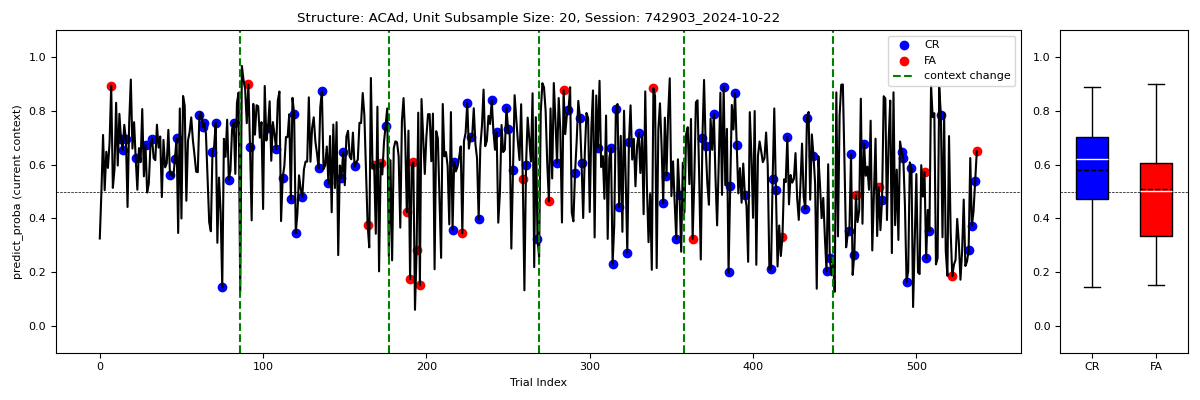

In [69]:
# Slightly different - color points as CR or FA

sel_structure='ACAd'
sel_unit_subsample=20
if sel_unit_subsample is None or sel_unit_subsample == 'all':
    structure_predict_proba=predict_proba_single_session_pd.query('structure==@sel_structure and unit_subsample_size.isna()')
else:
    structure_predict_proba=predict_proba_single_session_pd.query('structure==@sel_structure and unit_subsample_size==@sel_unit_subsample')

trial_index=structure_predict_proba['trial_index'].iloc[0]

stim_name=structure_predict_proba['stim_name'].iloc[0]
is_response=structure_predict_proba['is_response'].iloc[0]
is_vis_context=structure_predict_proba['is_vis_rewarded'].iloc[0]

structure_predict_proba_mean=np.mean(np.vstack(structure_predict_proba['predict_proba'].values),0)

structure_predict_proba_mean[~is_vis_context]=1-structure_predict_proba_mean[~is_vis_context]

CR_trials=(
    (stim_name=='sound1') & (is_response==False) & (is_vis_context==True)
) | (
    (stim_name=='vis1') & (is_response==False) & (is_vis_context==False)
)
FA_trials=(
    (stim_name=='sound1') & (is_response==True) & (is_vis_context==True)
) | (
    (stim_name=='vis1') & (is_response==True) & (is_vis_context==False)
)

is_change=np.diff(structure_predict_proba['is_vis_rewarded'].iloc[0], prepend=False, append=False)
change_idx=np.where(is_change)[0][:-1]

# CR_mean=np.mean(structure_predict_proba_mean[CR_trials])
# FA_mean=np.mean(structure_predict_proba_mean[FA_trials])

# fig,ax=plt.subplots(figsize=(12,4))
# gridspec to make a small subplot at the far right

fig = plt.figure(layout="constrained",figsize=(12, 4))
gs = GridSpec(1, 7, figure=fig)
ax = fig.add_subplot(gs[0, :-1]) #main plot

ax.axhline(0.5, color='k', linestyle='--', linewidth=0.5)
# ax.plot(trial_index, np.vstack(structure_predict_proba['predict_proba'].values).T, color='grey', alpha=0.25, linewidth=0.5)
ax.plot(trial_index, structure_predict_proba_mean, color='black')

ax.scatter(trial_index[CR_trials], 
           structure_predict_proba_mean[CR_trials], 
           color='blue', label='CR')
ax.scatter(trial_index[FA_trials], 
           structure_predict_proba_mean[FA_trials], 
           color='red', label='FA')

ax.vlines(change_idx, -0.1, 1.1, color='green', linestyle='--', label='context change')

ax.set_xlabel('Trial Index')
ax.set_ylabel('predict_proba (current context)')
ax.set_title(f'Structure: {sel_structure}, Unit Subsample Size: {sel_unit_subsample}, Session: {sel_session}')
ax.set_ylim(-0.1, 1.1)
ax.legend()

ax0=fig.add_subplot(gs[0, -1]) #small subplot on the right
ax0.axhline(0.5, color='k', linestyle='--', linewidth=0.5)
ax0.boxplot([structure_predict_proba_mean[CR_trials]],
            positions=[1], 
            widths=0.5, 
            patch_artist=True, 
            boxprops=dict(facecolor='blue', color='black'), 
            medianprops=dict(color='white'),
            meanline=True,
            showmeans=True,
            meanprops=dict(color='black'))
ax0.boxplot([structure_predict_proba_mean[FA_trials]],
            positions=[2], 
            widths=0.5, 
            patch_artist=True, 
            boxprops=dict(facecolor='red', color='black'), 
            medianprops=dict(color='white'),
            meanline=True,
            showmeans=True,
            meanprops=dict(color='black'))

ax0.set_xticks([1,2])
ax0.set_xticklabels(['CR', 'FA'])
ax0.set_ylim(-0.1, 1.1)

fig.tight_layout()


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_960\23539602.py:159: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


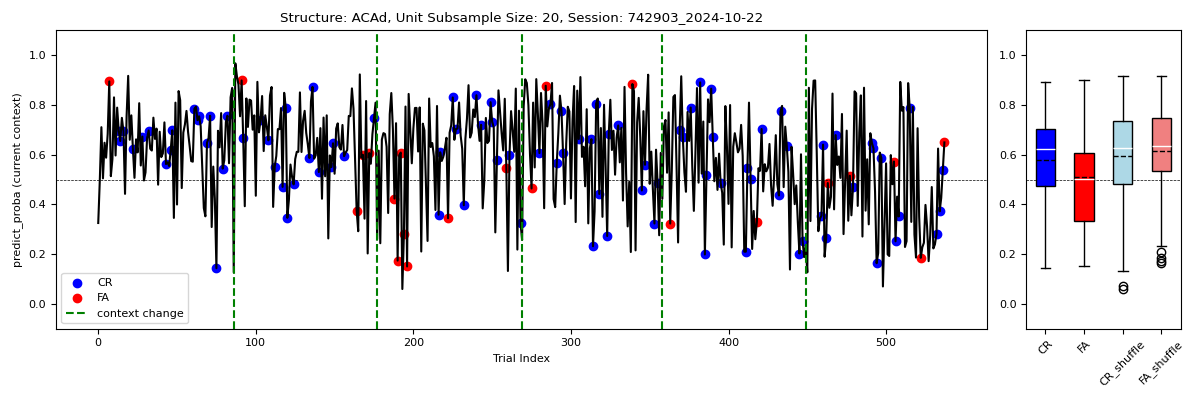

In [70]:
### TEST NULL DISTRIBUTION ON SINGLE SESSION

# 1- resample predict_proba with replacement N times
# 2- plot the average "null" predict proba
# 3- compute CR, FA nulls & plot

sel_structure='ACAd'
sel_unit_subsample=20
if sel_unit_subsample is None or sel_unit_subsample == 'all':
    structure_predict_proba=predict_proba_single_session_pd.query('structure==@sel_structure and unit_subsample_size.isna()')
else:
    structure_predict_proba=predict_proba_single_session_pd.query('structure==@sel_structure and unit_subsample_size==@sel_unit_subsample')

trial_index=structure_predict_proba['trial_index'].iloc[0]
stim_name=structure_predict_proba['stim_name'].iloc[0]
is_response=structure_predict_proba['is_response'].iloc[0]
is_vis_context=structure_predict_proba['is_vis_rewarded'].iloc[0]
trial_index_in_block=structure_predict_proba['trial_index_in_block'].iloc[0]
block_index=structure_predict_proba['block_index'].iloc[0]
is_change=np.diff(structure_predict_proba['is_vis_rewarded'].iloc[0], prepend=False, append=False)
change_idx=np.where(is_change)[0][:-1]

CR_trials=(
    (stim_name=='sound1') & (is_response==False) & (is_vis_context==True)
) | (
    (stim_name=='vis1') & (is_response==False) & (is_vis_context==False)
)
FA_trials=(
    (stim_name=='sound1') & (is_response==True) & (is_vis_context==True)
) | (
    (stim_name=='vis1') & (is_response==True) & (is_vis_context==False)
)

structure_predict_proba_mean=np.mean(np.vstack(structure_predict_proba['predict_proba'].values),0)
structure_predict_proba_mean[~is_vis_context]=1-structure_predict_proba_mean[~is_vis_context]

predict_proba_CR_FA_blockwise_shuffle={
    'labels_block':[],
    'predict_proba_block':[],
    'CR_predict_proba_all':[],
    'CR_predict_proba_mean':[],
    'FA_predict_proba_all':[],
    'FA_predict_proba_mean':[],
}


#loop through blocks
for label_block in np.unique(block_index):
    #loop through other possible blocks
    CR_block_idx=trial_index_in_block[(block_index==label_block) & CR_trials].astype(int)
    FA_block_idx=trial_index_in_block[(block_index==label_block) & FA_trials].astype(int)
    for predict_block in np.unique(block_index):
        if predict_block==label_block:
            continue
        #get predict_proba for current block
        predict_proba_block=structure_predict_proba_mean[block_index==predict_block]

        #Use CR and FA labels from label block, find predict proba from other block
        if np.any(CR_block_idx>len(predict_proba_block)-1):
            CR_block_idx=CR_block_idx[CR_block_idx<len(predict_proba_block)]
        CR_predict_proba_all=predict_proba_block[CR_block_idx]
        CR_predict_proba_mean=np.mean(CR_predict_proba_all)
        if np.any(FA_block_idx>len(predict_proba_block)-1):
            FA_block_idx=FA_block_idx[FA_block_idx<len(predict_proba_block)]
        FA_predict_proba_all=predict_proba_block[FA_block_idx]
        FA_predict_proba_mean=np.mean(FA_predict_proba_all)

        #append to dict
        predict_proba_CR_FA_blockwise_shuffle['labels_block'].append(label_block)
        predict_proba_CR_FA_blockwise_shuffle['predict_proba_block'].append(predict_block)
        predict_proba_CR_FA_blockwise_shuffle['CR_predict_proba_all'].append(CR_predict_proba_all)
        predict_proba_CR_FA_blockwise_shuffle['CR_predict_proba_mean'].append(CR_predict_proba_mean)
        predict_proba_CR_FA_blockwise_shuffle['FA_predict_proba_all'].append(FA_predict_proba_all)
        predict_proba_CR_FA_blockwise_shuffle['FA_predict_proba_mean'].append(FA_predict_proba_mean)

predict_proba_CR_FA_blockwise_shuffle_df=pd.DataFrame(predict_proba_CR_FA_blockwise_shuffle)

predict_proba_CR_FA_blockwise_shuffle_df

predict_proba_CR_shuffle_all=np.hstack(predict_proba_CR_FA_blockwise_shuffle_df['CR_predict_proba_all'].values)
predict_proba_FA_shuffle_all=np.hstack(predict_proba_CR_FA_blockwise_shuffle_df['FA_predict_proba_all'].values)

# n_resamples=100
# structure_predict_proba_resampled_mean=np.zeros((n_resamples, len(trial_index)))
# for i in range(n_resamples):
#     structure_predict_proba_resampled_mean[i,:]=structure_predict_proba_mean[
#         np.random.choice(len(structure_predict_proba_mean), size=(len(structure_predict_proba_mean)), replace=True)
#     ]


fig = plt.figure(layout="constrained",figsize=(12, 4))
gs = GridSpec(1, 6, figure=fig)
ax = fig.add_subplot(gs[0, :-1]) #main plot

ax.axhline(0.5, color='k', linestyle='--', linewidth=0.5)
# ax.plot(trial_index, np.vstack(structure_predict_proba['predict_proba'].values).T, color='grey', alpha=0.25, linewidth=0.5)
ax.plot(trial_index, structure_predict_proba_mean, color='black')

ax.scatter(trial_index[CR_trials], 
           structure_predict_proba_mean[CR_trials], 
           color='blue', label='CR')
ax.scatter(trial_index[FA_trials], 
           structure_predict_proba_mean[FA_trials], 
           color='red', label='FA')

ax.vlines(change_idx, -0.1, 1.1, color='green', linestyle='--', label='context change')

ax.set_xlabel('Trial Index')
ax.set_ylabel('predict_proba (current context)')
ax.set_title(f'Structure: {sel_structure}, Unit Subsample Size: {sel_unit_subsample}, Session: {sel_session}')
ax.set_ylim(-0.1, 1.1)
ax.legend()

ax0=fig.add_subplot(gs[0, -1]) #small subplot on the right
ax0.axhline(0.5, color='k', linestyle='--', linewidth=0.5)
ax0.boxplot([structure_predict_proba_mean[CR_trials]],
            positions=[1], 
            widths=0.5, 
            patch_artist=True, 
            boxprops=dict(facecolor='blue', color='black'), 
            medianprops=dict(color='white'),
            meanline=True,
            showmeans=True,
            meanprops=dict(color='black'))
ax0.boxplot([structure_predict_proba_mean[FA_trials]],
            positions=[2], 
            widths=0.5, 
            patch_artist=True, 
            boxprops=dict(facecolor='red', color='black'), 
            medianprops=dict(color='white'),
            meanline=True,
            showmeans=True,
            meanprops=dict(color='black'))

ax0.boxplot([predict_proba_CR_shuffle_all],
            positions=[3], 
            widths=0.5, 
            patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='black'), 
            medianprops=dict(color='white'),
            meanline=True,
            showmeans=True,
            meanprops=dict(color='black'))

ax0.boxplot([predict_proba_FA_shuffle_all],
            positions=[4], 
            widths=0.5, 
            patch_artist=True, 
            boxprops=dict(facecolor='lightcoral', color='black'), 
            medianprops=dict(color='white'),
            meanline=True,
            showmeans=True,
            meanprops=dict(color='black'))

ax0.set_xticks([1,2,3,4])
ax0.set_xticklabels(['CR', 'FA', 'CR_shuffle', 'FA_shuffle'],rotation=45)
ax0.set_ylim(-0.1, 1.1)

fig.tight_layout()


In [ ]:
FA_block_idx

In [ ]:
# fig,ax=plt.subplots(figsize=(12,4))
# ax.axhline(0.5, color='k', linestyle='--', linewidth=0.5)
# # ax.plot(trial_index, structure_predict_proba_resampled_mean.T, color='grey', alpha=0.25, linewidth=0.5)

# ax.plot(trial_index, np.mean(structure_predict_proba_resampled_mean,axis=0), color='grey', linestyle='--', label='mean resampled predict proba')
# ax.plot(trial_index, structure_predict_proba_mean, color='black', label='mean predict proba')

# ax.legend()

In [ ]:
# fig,ax=plt.subplots(1,1,figsize=(10,4))
# ax.plot(structure_predict_proba['is_vis_context'].iloc[0],'k.')
# is_change=np.diff(structure_predict_proba['is_vis_context'].iloc[0], prepend=False, append=False)
# ax.vlines(np.where(is_change)[0], 0, 1, color='red', linestyle='--')

In [ ]:
# session_table.columns
# performance['cross_modal_dprime'].mean()

In [5]:
structure_grouping = {
    'SCop': 'SCs',
    'SCsg': 'SCs',
    'SCzo': 'SCs',
    'SCig': 'SCm',
    'SCiw': 'SCm',
    'SCdg': 'SCm',
    'SCdw': 'SCm',
    "ECT1": 'ECT',
    "ECT2/3": 'ECT',    
    "ECT6b": 'ECT',
    "ECT5": 'ECT',
    "ECT6a": 'ECT', 
    "ECT4": 'ECT',
}
keep_original_structure = True
if keep_original_structure:
    n_repeats = 2

predict_proba_wo_repeats = (
    pl.scan_parquet(results_path)
    #make new column that indicates whether a row is the sole recording from a structure in a session
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),     
    )
    #Grab only rows according to combine_multi_probe_rec toggle
    #Grab only rows that have is_all_trials == True, only these have predict_proba
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials'),
    )
    #join on the units table to get total number of units per structure
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/units.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            #make new rows according to structure_grouping
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()))
                .then(pl.col('structure').repeat_by(n_repeats))
                .otherwise(pl.col('structure').repeat_by(1))
            )
            .explode('structure')
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()).is_first_distinct().over('unit_id'))
                .then(pl.col('structure').replace(structure_grouping))
                .otherwise(pl.col('structure'))
            )
            .group_by('session_id','structure')
            .agg(
                pl.col('unit_id').len().alias('total_n_units')
            )
        ),
        on=['session_id','structure'],
        how='left',
    )
    .with_columns(
        #pl.int_ranges(0, pl.col('predict_proba').list.len()).alias('trial_index')
        pl.col('trial_indices').alias('trial_index')
    )
    .drop('shift_idx', 'is_all_trials', 'electrode_group_names', 'unit_criteria', 'is_sole_recording')
    .explode('predict_proba', 'trial_index')
    .group_by('session_id', 'structure', 'unit_subsample_size', 'trial_index')
    .agg(
        pl.col('balanced_accuracy_test').mean(),
        pl.col('predict_proba').mean(),
        pl.col('total_n_units').first(),
        pl.col('unit_ids').first(),
    )
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/trials.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            .select('session_id', 'trial_index', 'is_vis_rewarded', 'stim_name', 'is_response')
        ),
        on=['session_id','trial_index'],
        how='inner',
    ) 
    .group_by('session_id', 'structure', 'unit_subsample_size')
    .agg(
        pl.col('balanced_accuracy_test').first(),
        pl.col('total_n_units').first(),
        pl.col('unit_ids').first(),
        pl.col('predict_proba', 'trial_index', 'is_vis_rewarded', 'stim_name', 'is_response').sort_by('trial_index'),

    )
    .sort('session_id','structure', 'unit_subsample_size')
    # .group_by('session_id','structure')
    .collect(engine='streaming')
)

In [6]:
predict_proba_wo_repeats

session_id,structure,unit_subsample_size,balanced_accuracy_test,total_n_units,unit_ids,predict_proba,trial_index,is_vis_rewarded,stim_name,is_response
str,str,u16,f64,u32,list[str],list[f64],list[u16],list[bool],list[str],list[bool]
"""620263_2022-07-26""","""ACAd""",10,0.600692,111,"[""620263_2022-07-26_F-181"", ""620263_2022-07-26_F-182"", … ""620263_2022-07-26_F-598""]","[0.727844, 0.75092, … 0.587904]","[0, 1, … 672]","[true, true, … true]","[""vis1"", ""vis1"", … ""catch""]","[true, true, … false]"
"""620263_2022-07-26""","""ACAv""",10,0.578428,277,"[""620263_2022-07-26_F-138"", ""620263_2022-07-26_F-362"", … ""620263_2022-07-26_F-79""]","[0.560015, 0.560007, … 0.491291]","[0, 1, … 672]","[true, true, … true]","[""vis1"", ""vis1"", … ""catch""]","[true, true, … false]"
"""620263_2022-07-26""","""CA1""",10,0.557636,456,"[""620263_2022-07-26_B-471"", ""620263_2022-07-26_C-124"", … ""620263_2022-07-26_C-67""]","[0.665214, 0.606697, … 0.51968]","[0, 1, … 672]","[true, true, … true]","[""vis1"", ""vis1"", … ""catch""]","[true, true, … false]"
"""620263_2022-07-26""","""DG""",10,0.555223,168,"[""620263_2022-07-26_B-103"", ""620263_2022-07-26_B-11"", … ""620263_2022-07-26_B-95""]","[0.499271, 0.461409, … 0.41072]","[0, 1, … 672]","[true, true, … true]","[""vis1"", ""vis1"", … ""catch""]","[true, true, … false]"
"""620263_2022-07-26""","""LSr""",10,0.529115,68,"[""620263_2022-07-26_F-14"", ""620263_2022-07-26_F-21"", … ""620263_2022-07-26_F-547""]","[0.470951, 0.547149, … 0.520438]","[0, 1, … 672]","[true, true, … true]","[""vis1"", ""vis1"", … ""catch""]","[true, true, … false]"
…,…,…,…,…,…,…,…,…,…,…
"""761583_2024-12-17""","""PO""",10,0.524132,242,"[""761583_2024-12-17_C-128"", ""761583_2024-12-17_C-624"", … ""761583_2024-12-17_E-78""]","[0.490673, 0.437486, … 0.517509]","[0, 1, … 508]","[false, false, … true]","[""sound1"", ""sound1"", … ""vis1""]","[true, true, … false]"
"""761583_2024-12-17""","""SSp""",10,0.537112,942,"[""761583_2024-12-17_A-312"", ""761583_2024-12-17_A-333"", … ""761583_2024-12-17_F-288""]","[0.52444, 0.360397, … 0.49858]","[0, 1, … 508]","[false, false, … true]","[""sound1"", ""sound1"", … ""vis1""]","[true, true, … false]"
"""761583_2024-12-17""","""VISam""",10,0.538015,126,"[""761583_2024-12-17_C-306"", ""761583_2024-12-17_C-317"", … ""761583_2024-12-17_C-590""]","[0.445306, 0.439742, … 0.545142]","[0, 1, … 508]","[false, false, … true]","[""sound1"", ""sound1"", … ""vis1""]","[true, true, … false]"


In [ ]:
# session_table['vis_cross_modal_dprime']

In [7]:
# predict_proba_wo_repeats.to_pandas().to_parquet(
#     r'\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\time_mod_keep_units_consistent_0_2025-06-15\predict_proba_per_session_structure_with_unit_ids.parquet')
predict_proba_wo_repeats.to_pandas().to_parquet(
    r'\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\decode_context_w_shifts_min_10_units_500ms_v272\predict_proba_per_session_structure_with_unit_ids.parquet')

In [8]:
predict_proba_pd=predict_proba_wo_repeats.to_pandas()

In [ ]:
# ##check the means over repeats work as expected

# test_session_area=predict_proba_pd.query('session_id=="742903_2024-10-22" and structure=="MOs" and unit_subsample_size==20')
# fig,ax=plt.subplots(figsize=(12,4))
# ax.plot(test_session_area['trial_index'].iloc[0], test_session_area['predict_proba'].iloc[0], color='grey')
# ax.plot(trial_index, np.mean(np.vstack(structure_predict_proba['predict_proba'].values),0), color='black', linestyle='--')


In [ ]:
predict_proba_pd['session_id'].unique().shape

In [ ]:
#join each session to trials table

# find hit, cr, fa trials - vis, aud, plus both contexts

In [ ]:
predict_proba_pd['predict_proba'].iloc[0].shape

In [ ]:
# trials.query('is_context_switch')['is_contingent_reward'].values

In [ ]:
###adapt this to polars?

#make a table of predict_proba for each confidence switch 

n_trials_before_switch=80
n_trials_after_switch=80
context_switch_predict_proba={
    'structure':[],
    'session_id':[],
    'project':[],
    'unit_subsample_size':[],
    'switch_index':[],
    'trial_index':[],
    'context_before':[],
    'context_after':[],
    'dprime_before':[],
    'dprime_after':[],
    # 'ccf_ap_mean':[],
    # 'ccf_dv_mean':[],
    # 'ccf_ml_mean':[],
    'predict_proba':[],
    'first_trial_is_contingent_reward':[],
    'n_units':[],
}

#predict proba mean for each response type
response_type_predict_proba={
    'session_id':[],
    'structure':[],
    'project':[],
    'unit_subsample_size':[],
    'vis_context_dprime':[],
    'aud_context_dprime':[],
    'overall_dprime':[],
    'n_good_blocks':[],

    'vis_hit_predict_proba':[],
    'vis_fa_predict_proba':[],
    'vis_cr_predict_proba':[],
    'aud_hit_predict_proba':[],
    'aud_fa_predict_proba':[],
    'aud_cr_predict_proba':[],
    'correct_predict_proba':[],
    'incorrect_predict_proba':[],
    'cr_all_predict_proba':[],
    'fa_all_predict_proba':[],
    'hit_all_predict_proba':[],

    'vis_hit_predict_proba_median':[],
    'vis_fa_predict_proba_median':[],
    'vis_cr_predict_proba_median':[],
    'aud_hit_predict_proba_median':[],
    'aud_fa_predict_proba_median':[],
    'aud_cr_predict_proba_median':[],
    'correct_predict_proba_median':[],
    'incorrect_predict_proba_median':[],
    'cr_all_predict_proba_median':[],
    'fa_all_predict_proba_median':[],
    'hit_all_predict_proba_median':[],

    # 'ccf_ap_mean':[],
    # 'ccf_dv_mean':[],
    # 'ccf_ml_mean':[],
    'n_units':[],
}

#predict proba mean for each response type
response_type_blockwise_predict_proba={
    'session_id':[],
    'structure':[],
    'project':[],
    'unit_subsample_size':[],
    'block_number':[],
    'is_vis_context':[],
    'is_aud_context':[],
    'block_dprime':[],

    'hit_predict_proba':[],
    'fa_predict_proba':[],
    'cr_predict_proba':[],
    'correct_predict_proba':[],
    'incorrect_predict_proba':[],

    # 'ccf_ap_mean':[],
    # 'ccf_dv_mean':[],
    # 'ccf_ml_mean':[],
    'n_units':[],
}

#before and after target/non target predict proba
before_after_target_predict_proba={
    'session_id':[],
    'structure':[],
    'project':[],
    'unit_subsample_size':[],
    'cross_modal_dprime':[],
    'n_good_blocks':[],
    'rewarded_target':[],
    'rewarded_target_plus_one':[],
    'non_rewarded_target':[],
    'non_rewarded_target_plus_one':[],
    'non_response_non_rewarded_target':[],
    'non_response_non_rewarded_target_plus_one':[],
    'non_response_non_target_trials':[],
    'non_response_non_target_trials_plus_one':[],
    # 'ccf_ap_mean':[],
    # 'ccf_dv_mean':[],
    # 'ccf_ml_mean':[],
    'n_units':[],
}

predict_proba_versus_trials_since_rewarded_target={
    'session':[],
    'structure':[],
    'project':[],
    'unit_subsample_size':[],
    'trial_index':[],
    'trials_since_rewarded_target':[],
    'time_since_rewarded_target':[],
    'trials_since_last_information':[],
    'time_since_last_information':[],
    'trials_since_last_information_no_targets':[],
    'time_since_last_information_no_targets':[],
    'predict_proba':[],
    # 'ccf_ap_mean':[],
    # 'ccf_dv_mean':[],
    # 'ccf_ml_mean':[],
    'n_units':[],
    'cross_modal_dprime':[],
    'n_good_blocks':[],
}

predict_proba_dprime_by_block={
    'session':[],
    'structure':[],
    'project':[],
    'unit_subsample_size':[],
    'block':[],
    'signed_cross_modal_dprime':[],
    'predict_proba':[],
    # 'ccf_ap_mean':[],
    # 'ccf_dv_mean':[],
    # 'ccf_ml_mean':[],
    'n_units':[],
}

sel_project='DynamicRouting'
unique_sessions=session_table.to_pandas().query('project==@sel_project')['session_id'].unique()

all_trials=pd.read_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.265/consolidated/trials.parquet')
all_performance=pd.read_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.265/consolidated/performance.parquet')

# #for each unique session
for session_id in unique_sessions:
    for sel_unit_subsample_size in predict_proba_pd['unit_subsample_size'].unique():

        # session_id=unique_sessions[0]

        session_confidence=predict_proba_pd.query('session_id==@session_id and unit_subsample_size==@sel_unit_subsample_size')

        if len(session_confidence)==0:
            print(f'session_id {session_id} has no predict_proba data, skipping...')
            continue

        #load trials table & performance table
        trials=all_trials.query('session_id==@session_id')
        performance=all_performance.query('session_id==@session_id')

        if len(session_confidence['predict_proba'].iloc[0])!=len(trials):
            print(f'session_id {session_id} has different number of trials than predict_proba table, skipping...')
            continue

        non_response_flag=False
        trials_since_rewarded_target=[]
        time_since_rewarded_target=[]
        last_rewarded_time=np.nan
        last_rewarded_trial=np.nan
        trials_since_last_information=[]
        time_since_last_information=[]
        last_informative_trial=np.nan
        last_informative_time=np.nan
        trials_since_last_information_no_targets=[]
        time_since_last_information_no_targets=[]
        for tt,trial in trials.iterrows():
            #track trials/time since last bit of information, exclude trials after non-responses to targets
            if non_response_flag==True:
                trials_since_last_information_no_targets.append(np.nan)
                time_since_last_information_no_targets.append(np.nan)
            else:
                trials_since_last_information_no_targets.append(tt-last_informative_trial)
                time_since_last_information_no_targets.append(trial['start_time']-last_informative_time)
            trials_since_last_information.append(tt-last_informative_trial)
            time_since_last_information.append(trial['start_time']-last_informative_time)

            #trials/time since last rewarded target
            trials_since_rewarded_target.append(tt-last_rewarded_trial)
            time_since_rewarded_target.append(trial['start_time']-last_rewarded_time)

            if trial['is_target'] and not trial['is_response']:
                non_response_flag=True
            elif trial['is_target'] and trial['is_response']:
                last_informative_time=trial['start_time']
                last_informative_trial=tt
                non_response_flag=False
            if trial['is_rewarded'] and trial['is_target']:
                last_rewarded_time=trial['reward_time']
                last_rewarded_trial=tt

        trials['trials_since_rewarded_target']=trials_since_rewarded_target
        trials['time_since_rewarded_target']=time_since_rewarded_target
        trials['trials_since_last_information']=trials_since_last_information
        trials['time_since_last_information']=time_since_last_information
        trials['trials_since_last_information_no_targets']=trials_since_last_information_no_targets
        trials['time_since_last_information_no_targets']=time_since_last_information_no_targets
        
        ### SWITCH ALIGNED PREDICT PROBA ###
        #find block switches
        block_switches=trials.query('is_context_switch').index.values
        #which block switches had contingent rewards?
        block_switch_is_contingent_reward=trials.query('is_context_switch')['is_contingent_reward'].values
        #for each structure (not including those with probe letters)
        session_structures=session_confidence['structure'].unique()

        for aa in session_structures:
            # aa=session_structures[0]
            structure_confidence=session_confidence.query('structure==@aa')
            structure_predict_proba=structure_confidence['predict_proba'].values[0]

            #for each switch
            for ss,switch in enumerate(block_switches):
                # switch=block_switches[0]
                # ss=0
                dprime_before=performance['cross_modal_dprime'].iloc[ss]
                dprime_after=performance['cross_modal_dprime'].iloc[ss+1]
                context_before=trials['context_name'].iloc[switch-1]
                context_after=trials['context_name'].iloc[switch]

                #save variables
                context_switch_predict_proba['structure'].append(aa)
                context_switch_predict_proba['session_id'].append(session_id)
                context_switch_predict_proba['project'].append(sel_project)
                context_switch_predict_proba['unit_subsample_size'].append(sel_unit_subsample_size)
                context_switch_predict_proba['switch_index'].append(ss)
                context_switch_predict_proba['trial_index'].append(switch)
                context_switch_predict_proba['context_before'].append(context_before)
                context_switch_predict_proba['context_after'].append(context_after)
                context_switch_predict_proba['dprime_before'].append(dprime_before)
                context_switch_predict_proba['dprime_after'].append(dprime_after)
                # context_switch_predict_proba['ccf_ap_mean'].append(structure_confidence['ccf_ap_mean'].values)
                # context_switch_predict_proba['ccf_dv_mean'].append(structure_confidence['ccf_dv_mean'].values)
                # context_switch_predict_proba['ccf_ml_mean'].append(structure_confidence['ccf_ml_mean'].values)
                # #check if trials exist
                if switch-n_trials_before_switch<0:
                    #if not, take the first n_trials_before_switch trials
                    switch_predict_proba=structure_predict_proba[0:switch+n_trials_after_switch]
                    #pad with nans
                    switch_predict_proba=np.concatenate((np.full((n_trials_before_switch-switch),np.nan),switch_predict_proba))

                elif switch+n_trials_after_switch>len(structure_predict_proba):
                    #if not, take the last n_trials_after_switch trials
                    switch_predict_proba=structure_predict_proba[switch-n_trials_before_switch:len(structure_predict_proba)]
                    #pad with nans
                    switch_predict_proba=np.concatenate((switch_predict_proba,np.full((switch+n_trials_after_switch-len(structure_predict_proba)),np.nan)))

                else:
                    switch_predict_proba=structure_predict_proba[switch-n_trials_before_switch:switch+n_trials_after_switch]
                    
                context_switch_predict_proba['predict_proba'].append(switch_predict_proba)
                context_switch_predict_proba['first_trial_is_contingent_reward'].append(block_switch_is_contingent_reward[ss])
                context_switch_predict_proba['n_units'].append(structure_confidence['total_n_units'].values[0])

        
            ### RESPONSE TYPE PREDICT PROBA ###

            #get trial indices for each type
            vis_HIT_idx=trials.query('(is_correct==True and is_target==True and is_vis_context==True \
                                        and is_response==True and is_reward_scheduled==False)').index.values
            aud_HIT_idx=trials.query('(is_correct==True and is_target==True and is_vis_context==False \
                                        and is_response==True and is_reward_scheduled==False)').index.values
            vis_CR_idx=trials.query('(is_correct==True and is_target==True and is_vis_context==True \
                                        and is_response==False and is_reward_scheduled==False)').index.values
            aud_CR_idx=trials.query('(is_correct==True and is_target==True and is_vis_context==False \
                                        and is_response==False and is_reward_scheduled==False)').index.values
            vis_FA_idx=trials.query('(is_correct==False and is_target==True and is_vis_context==True \
                                        and is_response==True and is_reward_scheduled==False)').index.values
            aud_FA_idx=trials.query('(is_correct==False and is_target==True and is_vis_context==False \
                                        and is_response==True and is_reward_scheduled==False)').index.values

            correct_vis_idx=trials.query('is_correct==True and is_target==True and is_reward_scheduled==False').index.values
            incorrect_vis_idx=trials.query('is_correct==False and is_target==True and is_reward_scheduled==False').index.values
            correct_aud_idx=trials.query('is_correct==True and is_target==True and is_reward_scheduled==False').index.values
            incorrect_aud_idx=trials.query('is_correct==False and is_target==True and is_reward_scheduled==False').index.values

            #find average predict_proba per hit, fa, cr
            vis_HIT_proba_mean=np.nanmean(structure_predict_proba[vis_HIT_idx])
            aud_HIT_proba_mean=np.nanmean(structure_predict_proba[aud_HIT_idx])
            vis_CR_proba_mean=np.nanmean(structure_predict_proba[vis_CR_idx])
            aud_CR_proba_mean=np.nanmean(structure_predict_proba[aud_CR_idx])
            vis_FA_proba_mean=np.nanmean(structure_predict_proba[vis_FA_idx])
            aud_FA_proba_mean=np.nanmean(structure_predict_proba[aud_FA_idx])

            correct_proba_mean=np.nanmean(np.hstack([structure_predict_proba[correct_vis_idx],1-structure_predict_proba[correct_aud_idx]]))
            incorrect_proba_mean=np.nanmean(np.hstack([structure_predict_proba[incorrect_vis_idx],1-structure_predict_proba[incorrect_aud_idx]]))

            CR_all_proba_mean=np.nanmean(np.hstack([structure_predict_proba[vis_CR_idx],1-structure_predict_proba[aud_CR_idx]]))
            FA_all_proba_mean=np.nanmean(np.hstack([structure_predict_proba[vis_FA_idx],1-structure_predict_proba[aud_FA_idx]]))
            HIT_all_proba_mean=np.nanmean(np.hstack([structure_predict_proba[vis_HIT_idx],1-structure_predict_proba[aud_HIT_idx]]))

            #find median predict_proba per hit, fa, cr
            vis_HIT_proba_median=np.nanmedian(structure_predict_proba[vis_HIT_idx])
            aud_HIT_proba_median=np.nanmedian(structure_predict_proba[aud_HIT_idx])
            vis_CR_proba_median=np.nanmedian(structure_predict_proba[vis_CR_idx])
            aud_CR_proba_median=np.nanmedian(structure_predict_proba[aud_CR_idx])
            vis_FA_proba_median=np.nanmedian(structure_predict_proba[vis_FA_idx])
            aud_FA_proba_median=np.nanmedian(structure_predict_proba[aud_FA_idx])

            correct_proba_median=np.nanmedian(np.hstack([structure_predict_proba[correct_vis_idx],1-structure_predict_proba[correct_aud_idx]]))
            incorrect_proba_median=np.nanmedian(np.hstack([structure_predict_proba[incorrect_vis_idx],1-structure_predict_proba[incorrect_aud_idx]]))

            CR_all_proba_median=np.nanmedian(np.hstack([structure_predict_proba[vis_CR_idx],1-structure_predict_proba[aud_CR_idx]]))
            FA_all_proba_median=np.nanmedian(np.hstack([structure_predict_proba[vis_FA_idx],1-structure_predict_proba[aud_FA_idx]]))
            HIT_all_proba_median=np.nanmedian(np.hstack([structure_predict_proba[vis_HIT_idx],1-structure_predict_proba[aud_HIT_idx]]))

            #save variables
            response_type_predict_proba['session_id'].append(session_id)
            response_type_predict_proba['structure'].append(aa)
            response_type_predict_proba['project'].append(sel_project)
            response_type_predict_proba['unit_subsample_size'].append(sel_unit_subsample_size)
            if performance.query('rewarded_modality=="vis"').empty:
                response_type_predict_proba['vis_context_dprime'].append(np.nan)
            else:
                response_type_predict_proba['vis_context_dprime'].append(performance.query('rewarded_modality=="vis"')['cross_modal_dprime'].values[0])
            if performance.query('rewarded_modality=="aud"').empty:
                response_type_predict_proba['aud_context_dprime'].append(np.nan)
            else:
                response_type_predict_proba['aud_context_dprime'].append(performance.query('rewarded_modality=="aud"')['cross_modal_dprime'].values[0])
            response_type_predict_proba['overall_dprime'].append(performance['cross_modal_dprime'].mean())
            response_type_predict_proba['n_good_blocks'].append(performance.query('cross_modal_dprime>=1.0')['cross_modal_dprime'].count())

            response_type_predict_proba['vis_hit_predict_proba'].append(vis_HIT_proba_mean)
            response_type_predict_proba['aud_hit_predict_proba'].append(aud_HIT_proba_mean)
            response_type_predict_proba['vis_cr_predict_proba'].append(vis_CR_proba_mean)
            response_type_predict_proba['aud_cr_predict_proba'].append(aud_CR_proba_mean)
            response_type_predict_proba['vis_fa_predict_proba'].append(vis_FA_proba_mean)
            response_type_predict_proba['aud_fa_predict_proba'].append(aud_FA_proba_mean)
            response_type_predict_proba['correct_predict_proba'].append(correct_proba_mean)
            response_type_predict_proba['incorrect_predict_proba'].append(incorrect_proba_mean)
            response_type_predict_proba['cr_all_predict_proba'].append(CR_all_proba_mean)
            response_type_predict_proba['fa_all_predict_proba'].append(FA_all_proba_mean)
            response_type_predict_proba['hit_all_predict_proba'].append(HIT_all_proba_mean)

            response_type_predict_proba['vis_hit_predict_proba_median'].append(vis_HIT_proba_median)
            response_type_predict_proba['aud_hit_predict_proba_median'].append(aud_HIT_proba_median)
            response_type_predict_proba['vis_cr_predict_proba_median'].append(vis_CR_proba_median)
            response_type_predict_proba['aud_cr_predict_proba_median'].append(aud_CR_proba_median)
            response_type_predict_proba['vis_fa_predict_proba_median'].append(vis_FA_proba_median)
            response_type_predict_proba['aud_fa_predict_proba_median'].append(aud_FA_proba_median)
            response_type_predict_proba['correct_predict_proba_median'].append(correct_proba_median)
            response_type_predict_proba['incorrect_predict_proba_median'].append(incorrect_proba_median)
            response_type_predict_proba['cr_all_predict_proba_median'].append(CR_all_proba_median)
            response_type_predict_proba['fa_all_predict_proba_median'].append(FA_all_proba_median)
            response_type_predict_proba['hit_all_predict_proba_median'].append(HIT_all_proba_median)

            # response_type_predict_proba['ccf_ap_mean'].append(structure_confidence['ccf_ap_mean'].values)
            # response_type_predict_proba['ccf_dv_mean'].append(structure_confidence['ccf_dv_mean'].values)
            # response_type_predict_proba['ccf_ml_mean'].append(structure_confidence['ccf_ml_mean'].values)
            response_type_predict_proba['n_units'].append(structure_confidence['total_n_units'].values[0])


            ### RESPONSE TYPE BLOCKWISE PREDICT PROBA ###
            #for each block
            blocks=trials['block_index'].unique()
            for bb,block in enumerate(blocks):

                block_trials=trials.query('block_index==@block')
                block_performance=performance.query('block_index==@block')

                HIT_idx=block_trials.query('(is_correct==True and is_target==True \
                                            and is_response==True and is_reward_scheduled==False)').index.values
                CR_idx=block_trials.query('(is_correct==True and is_target==True \
                                            and is_response==False and is_reward_scheduled==False)').index.values
                FA_idx=block_trials.query('(is_correct==False and is_target==True \
                                            and is_response==True and is_reward_scheduled==False)').index.values

                correct_idx=block_trials.query('is_correct==True and is_target==True and is_reward_scheduled==False').index.values
                incorrect_idx=block_trials.query('is_correct==False and is_target==True and is_reward_scheduled==False').index.values

                #find average predict_proba per hit, fa, cr
                HIT_proba_mean=np.nanmean(structure_predict_proba[HIT_idx])
                CR_proba_mean=np.nanmean(structure_predict_proba[CR_idx])
                FA_proba_mean=np.nanmean(structure_predict_proba[FA_idx])

                correct_proba_mean=np.nanmean(np.hstack([structure_predict_proba[correct_idx],1-structure_predict_proba[correct_aud_idx]]))
                incorrect_proba_mean=np.nanmean(np.hstack([structure_predict_proba[incorrect_idx],1-structure_predict_proba[incorrect_aud_idx]]))

                #save variables
                response_type_blockwise_predict_proba['session_id'].append(session_id)
                response_type_blockwise_predict_proba['structure'].append(aa)
                response_type_blockwise_predict_proba['project'].append(sel_project)
                response_type_blockwise_predict_proba['unit_subsample_size'].append(sel_unit_subsample_size)
                response_type_blockwise_predict_proba['block_number'].append(bb)
                response_type_blockwise_predict_proba['is_vis_context'].append(block_performance['rewarded_modality'].values[0]=='vis')
                response_type_blockwise_predict_proba['is_aud_context'].append(block_performance['rewarded_modality'].values[0]=='aud')
                response_type_blockwise_predict_proba['block_dprime'].append(block_performance['cross_modal_dprime'].values[0])

                response_type_blockwise_predict_proba['hit_predict_proba'].append(HIT_proba_mean)
                response_type_blockwise_predict_proba['cr_predict_proba'].append(CR_proba_mean)
                response_type_blockwise_predict_proba['fa_predict_proba'].append(FA_proba_mean)
                response_type_blockwise_predict_proba['correct_predict_proba'].append(correct_proba_mean)
                response_type_blockwise_predict_proba['incorrect_predict_proba'].append(incorrect_proba_mean)

                # response_type_blockwise_predict_proba['ccf_ap_mean'].append(structure_confidence['ccf_ap_mean'].values)
                # response_type_blockwise_predict_proba['ccf_dv_mean'].append(structure_confidence['ccf_dv_mean'].values)
                # response_type_blockwise_predict_proba['ccf_ml_mean'].append(structure_confidence['ccf_ml_mean'].values)
                response_type_blockwise_predict_proba['n_units'].append(structure_confidence['total_n_units'].values[0])


                #find average confidence and dprime for the block
                block_dprime=block_performance['signed_cross_modal_dprime'].values[0]
                block_predict_proba=np.nanmean(structure_predict_proba[block_trials.index.values])

                #append to table
                predict_proba_dprime_by_block['session'].append(session_id)
                predict_proba_dprime_by_block['structure'].append(aa)
                predict_proba_dprime_by_block['project'].append(sel_project)
                predict_proba_dprime_by_block['unit_subsample_size'].append(sel_unit_subsample_size)
                predict_proba_dprime_by_block['block'].append(bb)
                predict_proba_dprime_by_block['signed_cross_modal_dprime'].append(block_dprime)
                predict_proba_dprime_by_block['predict_proba'].append(block_predict_proba)
                predict_proba_dprime_by_block['n_units'].append(structure_confidence['total_n_units'].values[0])



            ### BEFORE/AFTER TARGET PREDICT PROBA ###
            #decoder confidence before/after rewarded target, response to non-rewarded target, non-response to non-rewarded target
            predict_proba_current_context=structure_predict_proba.copy()
            for tt,trial in trials.iterrows():
                if trial['is_aud_context']:
                    predict_proba_current_context[tt]=1-predict_proba_current_context[tt]
            #find trial and trial+1 of rewarded targets
            rewarded_target_trials=trials.query('is_rewarded==True and is_target==True and is_response==True and is_reward_scheduled==False').index.values
            rewarded_target_trials_plus_one=rewarded_target_trials+1
            if len(rewarded_target_trials_plus_one)>0:
                if rewarded_target_trials_plus_one[-1]>=len(structure_predict_proba):
                    rewarded_target_trials=rewarded_target_trials[:-1]
                    rewarded_target_trials_plus_one=rewarded_target_trials_plus_one[:-1]

            #find trials and trials+1 of responses to non-rewarded targets
            non_rewarded_target_trials=trials.query('is_rewarded==False and is_target==True and is_response==True').index.values
            non_rewarded_target_trials_plus_one=non_rewarded_target_trials+1
            if len(non_rewarded_target_trials_plus_one)>0:
                if non_rewarded_target_trials_plus_one[-1]>=len(structure_predict_proba):
                    non_rewarded_target_trials=non_rewarded_target_trials[:-1]
                    non_rewarded_target_trials_plus_one=non_rewarded_target_trials_plus_one[:-1]

            #find trials and trials+1 of non-response to non-rewarded targets
            non_response_non_rewarded_target_trials=trials.query('is_rewarded==False and is_target==True and is_response==False').index.values
            non_response_non_rewarded_target_trials_plus_one=non_response_non_rewarded_target_trials+1
            if len(non_response_non_rewarded_target_trials_plus_one)>0:
                if non_response_non_rewarded_target_trials_plus_one[-1]>=len(structure_predict_proba):
                    non_response_non_rewarded_target_trials=non_response_non_rewarded_target_trials[:-1]
                    non_response_non_rewarded_target_trials_plus_one=non_response_non_rewarded_target_trials_plus_one[:-1]

            non_response_non_target_trials=trials.query('is_rewarded==False and is_target==False and is_response==False').index.values
            non_response_non_target_trials_plus_one=non_response_non_target_trials+1
            if len(non_response_non_target_trials_plus_one)>0:
                if non_response_non_target_trials_plus_one[-1]>=len(structure_predict_proba):
                    non_response_non_target_trials=non_response_non_target_trials[:-1]
                    non_response_non_target_trials_plus_one=non_response_non_target_trials_plus_one[:-1]

            #append to table
            before_after_target_predict_proba['session_id'].append(session_id)
            before_after_target_predict_proba['structure'].append(aa)
            before_after_target_predict_proba['project'].append(sel_project)
            before_after_target_predict_proba['unit_subsample_size'].append(sel_unit_subsample_size)
            before_after_target_predict_proba['cross_modal_dprime'].append(performance['cross_modal_dprime'].mean())
            before_after_target_predict_proba['n_good_blocks'].append(np.sum(performance['cross_modal_dprime']>=1.0))
            before_after_target_predict_proba['rewarded_target'].append(predict_proba_current_context[rewarded_target_trials])
            before_after_target_predict_proba['rewarded_target_plus_one'].append(predict_proba_current_context[rewarded_target_trials_plus_one])
            if len(non_rewarded_target_trials)>0:
                before_after_target_predict_proba['non_rewarded_target'].append(predict_proba_current_context[non_rewarded_target_trials])
                before_after_target_predict_proba['non_rewarded_target_plus_one'].append(predict_proba_current_context[non_rewarded_target_trials_plus_one])
            else:
                before_after_target_predict_proba['non_rewarded_target'].append(np.nan)
                before_after_target_predict_proba['non_rewarded_target_plus_one'].append(np.nan)
            if len(non_response_non_rewarded_target_trials)>0:
                before_after_target_predict_proba['non_response_non_rewarded_target'].append(predict_proba_current_context[non_response_non_rewarded_target_trials])
                before_after_target_predict_proba['non_response_non_rewarded_target_plus_one'].append(predict_proba_current_context[non_response_non_rewarded_target_trials_plus_one])
            else:
                before_after_target_predict_proba['non_response_non_rewarded_target'].append(np.nan)
                before_after_target_predict_proba['non_response_non_rewarded_target_plus_one'].append(np.nan)
            before_after_target_predict_proba['non_response_non_target_trials'].append(predict_proba_current_context[non_response_non_target_trials])
            before_after_target_predict_proba['non_response_non_target_trials_plus_one'].append(predict_proba_current_context[non_response_non_target_trials_plus_one])

            # before_after_target_predict_proba['ccf_ap_mean'].append(structure_confidence['ccf_ap_mean'])
            # before_after_target_predict_proba['ccf_dv_mean'].append(structure_confidence['ccf_dv_mean'])
            # before_after_target_predict_proba['ccf_ml_mean'].append(structure_confidence['ccf_ml_mean'])
            before_after_target_predict_proba['n_units'].append(structure_confidence['total_n_units'].values[0])


            #find decoder confidence according to time/trials since last rewarded target
            #3 arrays - time since last rewarded target, trials since last rewarded target, decoder confidence
            trials_since_rewarded_target=trials.query('is_reward_scheduled==False')['trials_since_rewarded_target'].values
            time_since_rewarded_target=trials.query('is_reward_scheduled==False')['time_since_rewarded_target'].values
            predict_proba_corrected=structure_predict_proba.copy()
            for tt,trial in trials.query('is_reward_scheduled==False').reset_index().iterrows():
                #reverse sign if other modality
                if trial['is_aud_context']:
                    predict_proba_corrected[tt]=1-predict_proba_corrected[tt]

            #append to table per session and area
            predict_proba_versus_trials_since_rewarded_target['session'].append(session_id)
            predict_proba_versus_trials_since_rewarded_target['structure'].append(aa)
            predict_proba_versus_trials_since_rewarded_target['project'].append(sel_project)
            predict_proba_versus_trials_since_rewarded_target['unit_subsample_size'].append(sel_unit_subsample_size)
            predict_proba_versus_trials_since_rewarded_target['trial_index'].append(trials.index.values)
            predict_proba_versus_trials_since_rewarded_target['trials_since_rewarded_target'].append(trials_since_rewarded_target)
            predict_proba_versus_trials_since_rewarded_target['time_since_rewarded_target'].append(time_since_rewarded_target)
            predict_proba_versus_trials_since_rewarded_target['predict_proba'].append(predict_proba_corrected)

            #trials/time since last bit of information
            trials_since_last_information=trials['trials_since_last_information'].values
            time_since_last_information=trials['time_since_last_information'].values

            predict_proba_versus_trials_since_rewarded_target['trials_since_last_information'].append(trials_since_last_information)
            predict_proba_versus_trials_since_rewarded_target['time_since_last_information'].append(time_since_last_information)

            #trials/time since last bit of information, excluding trials after non-responses to targets
            trials_since_last_information_no_targets=trials['trials_since_last_information_no_targets'].values
            time_since_last_information_no_targets=trials['time_since_last_information_no_targets'].values

            predict_proba_versus_trials_since_rewarded_target['trials_since_last_information_no_targets'].append(trials_since_last_information_no_targets)
            predict_proba_versus_trials_since_rewarded_target['time_since_last_information_no_targets'].append(time_since_last_information_no_targets)

            # # 'ccf_ap_mean', 'ccf_dv_mean', 'ccf_ml_mean'
            # if 'ccf_ap_mean' in decoder_results[session_id]['results'][aa].keys():
            #     predict_proba_versus_trials_since_rewarded_target['ccf_ap_mean'].append(decoder_results[session_id]['results'][aa]['ccf_ap_mean'])
            #     predict_proba_versus_trials_since_rewarded_target['ccf_dv_mean'].append(decoder_results[session_id]['results'][aa]['ccf_dv_mean'])
            #     predict_proba_versus_trials_since_rewarded_target['ccf_ml_mean'].append(decoder_results[session_id]['results'][aa]['ccf_ml_mean'])
            #     predict_proba_versus_trials_since_rewarded_target['n_units'].append(decoder_results[session_id]['results'][aa]['n_units'])
            # else:
            #     predict_proba_versus_trials_since_rewarded_target['ccf_ap_mean'].append(np.nan)
            #     predict_proba_versus_trials_since_rewarded_target['ccf_dv_mean'].append(np.nan)
            #     predict_proba_versus_trials_since_rewarded_target['ccf_ml_mean'].append(np.nan)
                # predict_proba_versus_trials_since_rewarded_target['n_units'].append(np.nan)

            predict_proba_versus_trials_since_rewarded_target['n_units'].append(structure_confidence['total_n_units'].values[0])

            predict_proba_versus_trials_since_rewarded_target['cross_modal_dprime'].append(performance['cross_modal_dprime'].mean())
            predict_proba_versus_trials_since_rewarded_target['n_good_blocks'].append(np.sum(performance['cross_modal_dprime']>=1.0))


context_switch_predict_proba=pd.DataFrame(context_switch_predict_proba)
response_type_predict_proba=pd.DataFrame(response_type_predict_proba)
before_after_target_predict_proba=pd.DataFrame(before_after_target_predict_proba)
response_type_blockwise_predict_proba=pd.DataFrame(response_type_blockwise_predict_proba)
predict_proba_versus_trials_since_rewarded_target=pd.DataFrame(predict_proba_versus_trials_since_rewarded_target)
predict_proba_dprime_by_block=pd.DataFrame(predict_proba_dprime_by_block)


In [ ]:
# session_table.to_pandas().query('project==@sel_project and is_production')
# context_switch_predict_proba['session_id'].unique().shape

In [ ]:
# #save tables
# context_switch_predict_proba.to_parquet(
#     r'\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\binsize testing\context_switch_predict_proba_binsize_15.parquet')
# response_type_predict_proba.to_parquet(
#     r'\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\binsize testing\response_type_predict_proba_binsize_15.parquet')
# response_type_blockwise_predict_proba.to_parquet(
#     r'\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\binsize testing\response_type_blockwise_predict_proba_binsize_15.parquet')
# before_after_target_predict_proba.to_parquet(
#     r'\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\binsize testing\before_after_target_predict_proba_binsize_15.parquet')
# predict_proba_versus_trials_since_rewarded_target.to_parquet(
#     r'\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\binsize testing\predict_proba_versus_trials_since_rewarded_target_binsize_15.parquet')
# predict_proba_dprime_by_block.to_parquet(
#     r'\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\binsize testing\predict_proba_dprime_by_block_binsize_15.parquet')


In [ ]:
predict_proba_dprime_by_block

In [ ]:
#load tables
context_switch_predict_proba=pd.read_parquet(r'\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\new_decoder_run_2025-04-04\context_switch_predict_proba.parquet')
response_type_predict_proba=pd.read_parquet(r'\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\new_decoder_run_2025-04-04\response_type_predict_proba.parquet')
response_type_blockwise_predict_proba=pd.read_parquet(r'\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\new_decoder_run_2025-04-04\response_type_blockwise_predict_proba.parquet')
before_after_target_predict_proba=pd.read_parquet(r'\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\new_decoder_run_2025-04-04\before_after_target_predict_proba.parquet')
predict_proba_versus_trials_since_rewarded_target=pd.read_parquet(r'\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\new_decoder_run_2025-04-04\predict_proba_versus_trials_since_rewarded_target.parquet')
predict_proba_dprime_by_block=pd.read_parquet(r'\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\new_decoder_run_2025-04-04\predict_proba_dprime_by_block.parquet')

In [ ]:
n_trials_before_switch=80
n_trials_after_switch=80

In [ ]:
#context switch - example structure

sel_structure='MOs'
sel_unit_subsample_size=20
dprime_threshold=1.0

sel_data=context_switch_predict_proba.query('structure==@sel_structure and dprime_before>=@dprime_threshold and dprime_after>=@dprime_threshold and \
                                            unit_subsample_size==@sel_unit_subsample_size and project=="DynamicRouting"')

vis_to_aud_switch_mean=np.nanmean(np.vstack(sel_data.query('context_before=="vis" and context_after=="aud"')['predict_proba'].values),axis=0)
vis_to_aud_switch_sem=stats.sem(np.vstack(sel_data.query('context_before=="vis" and context_after=="aud"')['predict_proba'].values),axis=0,nan_policy='omit')
vis_to_aud_switch_n=len(sel_data.query('context_before=="vis" and context_after=="aud"'))
aud_to_vis_switch_mean=np.nanmean(np.vstack(sel_data.query('context_before=="aud" and context_after=="vis"')['predict_proba'].values),axis=0)
aud_to_vis_switch_sem=stats.sem(np.vstack(sel_data.query('context_before=="aud" and context_after=="vis"')['predict_proba'].values),axis=0,nan_policy='omit')
aud_to_vis_switch_n=len(sel_data.query('context_before=="aud" and context_after=="vis"'))

xvect=np.arange(-n_trials_before_switch,n_trials_after_switch) #x vector for plotting, trials since switch

fig,ax=plt.subplots(figsize=(5,4))
ax.plot(xvect,vis_to_aud_switch_mean,color='tab:blue',marker='.',label=f'V -> A ({vis_to_aud_switch_n})',alpha=0.8)
ax.fill_between(xvect,vis_to_aud_switch_mean-vis_to_aud_switch_sem,vis_to_aud_switch_mean+vis_to_aud_switch_sem,alpha=0.2,color='tab:blue')
ax.plot(xvect,aud_to_vis_switch_mean,color='tab:green',marker='.',label=f'A -> V ({aud_to_vis_switch_n})',alpha=0.8)
ax.fill_between(xvect,aud_to_vis_switch_mean-aud_to_vis_switch_sem,aud_to_vis_switch_mean+aud_to_vis_switch_sem,alpha=0.2,color='tab:green')

ax.axvline(-0.5,color='k',linewidth=1.0,alpha=0.5,linestyle='--')
ax.axhline(0.5,color='k',linewidth=1.0,alpha=0.5,linestyle='--')

ax.set_xlabel('trials since context switch')
ax.set_ylabel('p(vis context)')
ax.legend()

ax.set_title(sel_structure+' units; n='+str(len(sel_data.query('switch_index==0')))+' sessions; unit_subsample_size='+str(sel_unit_subsample_size))

fig.tight_layout()


In [ ]:
#context switch contingent vs. non-contingent switches

#context switch - example structure

sel_structure='SCm'
sel_unit_subsample_size=20
dprime_threshold=0

sel_data=context_switch_predict_proba.query('structure==@sel_structure and dprime_before>=@dprime_threshold and dprime_after>=@dprime_threshold and \
                                            unit_subsample_size==@sel_unit_subsample_size and project=="DynamicRouting"')

vis_to_aud_switch_contingent_mean=np.nanmean(np.vstack(sel_data.query('context_before=="vis" and context_after=="aud" and first_trial_is_contingent_reward')['predict_proba'].values),axis=0)
vis_to_aud_switch_contingent_sem=stats.sem(np.vstack(sel_data.query('context_before=="vis" and context_after=="aud" and first_trial_is_contingent_reward')['predict_proba'].values),axis=0,nan_policy='omit')
vis_to_aud_switch_contingent_n=len(sel_data.query('context_before=="vis" and context_after=="aud" and first_trial_is_contingent_reward'))
aud_to_vis_switch_contingent_mean=np.nanmean(np.vstack(sel_data.query('context_before=="aud" and context_after=="vis" and first_trial_is_contingent_reward')['predict_proba'].values),axis=0)
aud_to_vis_switch_contingent_sem=stats.sem(np.vstack(sel_data.query('context_before=="aud" and context_after=="vis" and first_trial_is_contingent_reward')['predict_proba'].values),axis=0,nan_policy='omit')
aud_to_vis_switch_contingent_n=len(sel_data.query('context_before=="aud" and context_after=="vis" and first_trial_is_contingent_reward'))

vis_to_aud_switch_noncontingent_mean=np.nanmean(np.vstack(sel_data.query('context_before=="vis" and context_after=="aud" and ~first_trial_is_contingent_reward')['predict_proba'].values),axis=0)
vis_to_aud_switch_noncontingent_sem=stats.sem(np.vstack(sel_data.query('context_before=="vis" and context_after=="aud" and ~first_trial_is_contingent_reward')['predict_proba'].values),axis=0,nan_policy='omit')
vis_to_aud_switch_noncontingent_n=len(sel_data.query('context_before=="vis" and context_after=="aud" and ~first_trial_is_contingent_reward'))
aud_to_vis_switch_noncontingent_mean=np.nanmean(np.vstack(sel_data.query('context_before=="aud" and context_after=="vis" and ~first_trial_is_contingent_reward')['predict_proba'].values),axis=0)
aud_to_vis_switch_noncontingent_sem=stats.sem(np.vstack(sel_data.query('context_before=="aud" and context_after=="vis" and ~first_trial_is_contingent_reward')['predict_proba'].values),axis=0,nan_policy='omit')
aud_to_vis_switch_noncontingent_n=len(sel_data.query('context_before=="aud" and context_after=="vis" and ~first_trial_is_contingent_reward'))

xvect=np.arange(-n_trials_before_switch,n_trials_after_switch) #x vector for plotting, trials since switch

fig,ax=plt.subplots(figsize=(5,4))

ax.plot(xvect,vis_to_aud_switch_noncontingent_mean,color='tab:blue',marker='^',linestyle='-',
        label=f'V -> A non-contingent ({vis_to_aud_switch_noncontingent_n})',alpha=0.8)
ax.fill_between(xvect,vis_to_aud_switch_noncontingent_mean-vis_to_aud_switch_noncontingent_sem,
                vis_to_aud_switch_noncontingent_mean+vis_to_aud_switch_noncontingent_sem,alpha=0.2,color='tab:blue')
ax.plot(xvect,aud_to_vis_switch_noncontingent_mean,color='tab:green',marker='^',linestyle='-',
        label=f'A -> V non-contingent ({aud_to_vis_switch_noncontingent_n})',alpha=0.8)
ax.fill_between(xvect,aud_to_vis_switch_noncontingent_mean-aud_to_vis_switch_noncontingent_sem,
                aud_to_vis_switch_noncontingent_mean+aud_to_vis_switch_noncontingent_sem,alpha=0.2,color='tab:green')

ax.plot(xvect,vis_to_aud_switch_contingent_mean,color='tab:blue',marker='.',linestyle='--',
        label=f'V -> A contingent ({vis_to_aud_switch_contingent_n})',alpha=0.8)
ax.fill_between(xvect,vis_to_aud_switch_contingent_mean-vis_to_aud_switch_contingent_sem,
                vis_to_aud_switch_contingent_mean+vis_to_aud_switch_contingent_sem,alpha=0.2,color='tab:blue')
ax.plot(xvect,aud_to_vis_switch_contingent_mean,color='tab:green',marker='.',linestyle='--',
        label=f'A -> V contingent ({aud_to_vis_switch_contingent_n})',alpha=0.8)
ax.fill_between(xvect,aud_to_vis_switch_contingent_mean-aud_to_vis_switch_contingent_sem,
                aud_to_vis_switch_contingent_mean+aud_to_vis_switch_contingent_sem,alpha=0.2,color='tab:green')


ax.axvline(-0.5,color='k',linewidth=1.0,alpha=0.5,linestyle='--')
ax.axhline(0.5,color='k',linewidth=1.0,alpha=0.5,linestyle='--')

ax.set_xlabel('trials since context switch')
ax.set_ylabel('p(vis context)')
ax.legend()

ax.set_title(sel_structure+' units; n='+str(len(sel_data.query('switch_index==0')))+' sessions; unit_subsample_size='+str(sel_unit_subsample_size))

ax.set_xlim(-5,10)

fig.tight_layout()


In [ ]:
#context switch comparison across structures

sel_structures=['SCm','MRN','ACAd','MOs','VISp','CA1']
dprime_threshold=1.0
sel_unit_subsample_size=20

fig,ax=plt.subplots(2,1,figsize=(5,8),sharex=True,sharey=True)

for sel_structure in sel_structures:

    sel_data=context_switch_predict_proba.query('structure==@sel_structure and dprime_before>=@dprime_threshold and dprime_after>=@dprime_threshold and \
                                                unit_subsample_size==@sel_unit_subsample_size and project=="DynamicRouting"')

    vis_to_aud_switch_mean=np.nanmean(np.vstack(sel_data.query('context_before=="vis" and context_after=="aud"')['predict_proba'].values),axis=0)
    vis_to_aud_switch_sem=stats.sem(np.vstack(sel_data.query('context_before=="vis" and context_after=="aud"')['predict_proba'].values),axis=0,nan_policy='omit')
    vis_to_aud_switch_n=len(sel_data.query('context_before=="vis" and context_after=="aud"'))
    aud_to_vis_switch_mean=np.nanmean(np.vstack(sel_data.query('context_before=="aud" and context_after=="vis"')['predict_proba'].values),axis=0)
    aud_to_vis_switch_sem=stats.sem(np.vstack(sel_data.query('context_before=="aud" and context_after=="vis"')['predict_proba'].values),axis=0,nan_policy='omit') # use omit to ignore nans in the calculation of the sem, otherwise it will return nan if any nans are present in the array
    aud_to_vis_switch_n=len(sel_data.query('context_before=="aud" and context_after=="vis"'))

    line=ax[0].plot(xvect,vis_to_aud_switch_mean,marker='.',label=sel_structure,alpha=0.8)
    ax[0].fill_between(xvect,vis_to_aud_switch_mean-vis_to_aud_switch_sem,vis_to_aud_switch_mean+vis_to_aud_switch_sem,alpha=0.2,color=line[0].get_color())

    line=ax[1].plot(xvect,aud_to_vis_switch_mean,marker='.',label=sel_structure,alpha=0.8)
    ax[1].fill_between(xvect,aud_to_vis_switch_mean-aud_to_vis_switch_sem,aud_to_vis_switch_mean+aud_to_vis_switch_sem,alpha=0.2,color=line[0].get_color())

ax[0].axvline(-0.5,color='k',linewidth=1.0,alpha=0.5,linestyle='--')
ax[1].axvline(-0.5,color='k',linewidth=1.0,alpha=0.5,linestyle='--')

ax[0].axhline(0.5,color='k',linewidth=1.0,alpha=0.5,linestyle='--')
ax[1].axhline(0.5,color='k',linewidth=1.0,alpha=0.5,linestyle='--')

ax[0].set_xlabel('trials since context switch')
ax[0].set_ylabel('p(vis context)')
ax[0].set_title('V -> A; unit_subsample_size='+str(sel_unit_subsample_size))
ax[0].legend()

ax[1].set_xlabel('trials since context switch')
ax[1].set_ylabel('p(vis context)')
ax[1].set_title('A -> V; unit_subsample_size='+str(sel_unit_subsample_size))
ax[1].legend()

fig.tight_layout()


In [ ]:
# get ITIs for each session + switch

n_trials_before_switch=80
n_trials_after_switch=80

all_trials=pd.read_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.265/consolidated/trials.parquet')

all_itis={
    'session_id':[],
    'trial_index':[],
    'previous_iti':[],
}

for sel_session_id in all_trials['session_id'].unique():

    session_trials=all_trials.query('session_id==@sel_session_id')
    session_context_switches=session_trials.query('is_context_switch==True').index.values

    for switch_trial_index in session_context_switches:
        
        current_trials=session_trials.query('trial_index>=@switch_trial_index-@n_trials_before_switch and trial_index<@switch_trial_index+@n_trials_after_switch')['stim_start_time'].values
        previous_trials=session_trials.query('trial_index>=@switch_trial_index-@n_trials_before_switch-1 and trial_index<@switch_trial_index+@n_trials_after_switch-1')['stim_start_time'].values

        if switch_trial_index-n_trials_before_switch<0:
            # #if not, take the first n_trials_before_switch trials
            # current_trials=session_trials.query('trial_index<@switch_trial_index+@n_trials_after_switch')['stim_start_time'].values
            # previous_trials=session_trials.query('trial_index<@switch_trial_index-1')['stim_start_time'].values
            #pad with nans with numpy.concatenate
            current_trials_=np.concatenate((np.array([np.nan]*(n_trials_before_switch-switch_trial_index)),current_trials))
            previous_trials_=np.concatenate((np.array([np.nan]*(n_trials_before_switch-switch_trial_index+1)),previous_trials))

        elif switch_trial_index+n_trials_after_switch>len(session_trials):
            # #if not, take the last n_trials_after_switch trials
            # current_trials=session_trials.query('trial_index>=@switch_trial_index-@n_trials_before_switch')['stim_start_time'].values
            # previous_trials=session_trials.query('trial_index>=@switch_trial_index-@n_trials_before_switch-1')['stim_start_time'].values
            #pad with nans with numpy.concatenate
            current_trials_=np.concatenate((current_trials,np.array([np.nan]*(switch_trial_index+n_trials_after_switch-len(current_trials)))))
            previous_trials_=np.concatenate((previous_trials,np.array([np.nan]*(switch_trial_index+n_trials_after_switch-len(previous_trials)))))
        else:
            current_trials_=current_trials
            previous_trials_=previous_trials

        previous_iti=current_trials_-previous_trials_

        all_itis['session_id'].append(sel_session_id)
        all_itis['trial_index'].append(switch_trial_index)
        all_itis['previous_iti'].append(previous_iti)

all_itis=pd.DataFrame(all_itis)

In [ ]:
all_itis

In [ ]:
merge=pd.merge(context_switch_predict_proba,all_itis,left_on=['session_id','trial_index'],right_on=['session_id','trial_index'],how='left')

rel_trial_index=np.arange(-n_trials_before_switch,n_trials_after_switch)
switch_index=np.where(rel_trial_index==0)[0][0]

get_trials_rel_to_switch=[-1,0,1,2]

trial_specific_predict_proba={
    'session_id':[],
    'trial_index':[],
    'unit_subsample_size':[],
    'structure':[],
}

for tt in get_trials_rel_to_switch:
    trial_specific_predict_proba['predict_proba_change_trial_'+str(tt)]=[]
    trial_specific_predict_proba['previous_iti_trial_'+str(tt)]=[]

for rr,row in merge.iterrows():
    trial_specific_predict_proba['session_id'].append(row['session_id'])
    trial_specific_predict_proba['trial_index'].append(row['trial_index'])
    trial_specific_predict_proba['unit_subsample_size'].append(row['unit_subsample_size'])
    trial_specific_predict_proba['structure'].append(row['structure'])
    for tt in get_trials_rel_to_switch:
        trial_specific_predict_proba['predict_proba_change_trial_'+str(tt)].append(row['predict_proba'][switch_index+tt]-row['predict_proba'][switch_index+tt-1])
        trial_specific_predict_proba['previous_iti_trial_'+str(tt)].append(row['previous_iti'][switch_index+tt])

trial_specific_predict_proba=pd.DataFrame(trial_specific_predict_proba)

merge=pd.merge(merge,trial_specific_predict_proba,left_on=['session_id','trial_index','unit_subsample_size','structure'],right_on=['session_id','trial_index','unit_subsample_size','structure'],how='left')
merge

In [ ]:
sel_structure='MOs'
test=merge.query('structure==@sel_structure and dprime_before>=0.5 and dprime_after>=0.5 and \
            unit_subsample_size==@sel_unit_subsample_size and project=="DynamicRouting" and \
            context_before=="vis" and context_after=="aud" and first_trial_is_contingent_reward==False')

fig,ax=plt.subplots(1,4,figsize=(12,3.5),sharex=True,sharey=True)

for ii,tt in enumerate(get_trials_rel_to_switch):
    # linregress_result=stats.linregress(test['previous_iti_trial_'+str(tt)].values,test['predict_proba_change_trial_'+str(tt)].values,)
    r,p_value=stats.pearsonr(test['previous_iti_trial_'+str(tt)].values,test['predict_proba_change_trial_'+str(tt)].values)
    ax[ii].plot(test['previous_iti_trial_'+str(tt)].values,test['predict_proba_change_trial_'+str(tt)].values,marker='.',linestyle='',alpha=0.5)
    # ax[ii].set_title('switch trial + '+str(tt)+' slope='+str(round(linregress_result.slope,3))+'; p='+str(round(linregress_result.pvalue,3)))
    ax[ii].set_title('switch trial + '+str(tt)+' r='+str(round(r,3))+'; p='+str(round(p_value,3)))
    ax[ii].set_xlabel('previous_iti '+str(tt))
    ax[ii].set_ylabel('predict_proba '+str(tt))
    ax[ii].set_xlim(5,15)
    # ax[ii].set_ylim(0,1)
    # ax[ii].set_aspect('equal')

fig.suptitle(sel_structure+' units; n='+str(len(test))+' switches; unit_subsample_size='+str(sel_unit_subsample_size))
fig.tight_layout()


In [ ]:
n_trials_before_switch=80
n_trials_after_switch=80

switch_trial_index=row['trial_index']
current_trials=session_trials.query('trial_index>=@switch_trial_index-@n_trials_before_switch and trial_index<@switch_trial_index+@n_trials_after_switch')
previous_trials=session_trials.query('trial_index>=@switch_trial_index-@n_trials_before_switch-1 and trial_index<@switch_trial_index+@n_trials_after_switch-1')

previous_iti=current_trials['stim_start_time'].values-previous_trials['stim_start_time'].values

In [ ]:
# single structure CR vs. FA

dprime_threshold=1.0
sel_project='DynamicRouting'
sel_unit_subsample_size=40
min_n_recs=3
use_median=False
if use_median:
    median_str='_median'
else:
    median_str=''

ss='MOs'

sel_structure=response_type_predict_proba.query('structure==@ss and vis_context_dprime>=@dprime_threshold and aud_context_dprime>=@dprime_threshold and \
                                                unit_subsample_size==@sel_unit_subsample_size and project.str.contains(@sel_project)')

fig,ax=plt.subplots(1,1,figsize=(4,4))
#make boxplot of each response type
bplot=ax.boxplot(sel_structure[['vis_hit_predict_proba'+median_str,'vis_cr_predict_proba'+median_str,'vis_fa_predict_proba'+median_str,
                    'aud_hit_predict_proba'+median_str,'aud_cr_predict_proba'+median_str,'aud_fa_predict_proba'+median_str]].values,
                    positions=[0,1,2,3,4,5],patch_artist=True,medianprops={"color": "white", "linewidth": 1.0},)

ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(['vis_HIT','vis_CR','vis_FA','aud_HIT','aud_CR','aud_FA'],rotation=90)
fill_colors=['tab:green','tab:blue','tab:red','tab:green','tab:blue','tab:red']
# fill with colors
for patch, color in zip(bplot['boxes'], fill_colors):
    patch.set_facecolor(color)

ax.axhline(0.5,color='k',linewidth=0.5)
ax.set_title(str(ss)+' n='+str(len(sel_structure))+'; context dprime>='+str(dprime_threshold))
ax.set_ylabel('p(vis context)')
# ax.set_ylim([0,1])

fig.tight_layout()

In [ ]:
dprime_threshold=1.0
sel_project='DynamicRouting'
min_n_sessions=3
sel_unit_subsample_size=20

use_median=False
if use_median:
    median_str='_median'
else:
    median_str=''

cr_fa_diff_by_structure={
    'structure':[],
    'n_sessions':[],
    'vis_context_dprime':[],
    'vis_context_cr_fa_diff':[],
    'vis_context_cr_fa_diff_sem':[],
    'aud_context_dprime':[],
    'aud_context_cr_fa_diff':[],
    'aud_context_cr_fa_diff_sem':[],
    'mean_diff':[],
    'mean_diff_sem':[],
    'total_diff':[],
}

for ss in response_type_predict_proba['structure'].unique():
    # sel_structure=decoder_confidence_versus_response_type.query('structure==@aa and vis_context_dprime>=@dprime_threshold and aud_context_dprime>=@dprime_threshold and project.str.contains(@sel_project)')
    sel_structure=response_type_predict_proba.query('structure==@ss and n_good_blocks>=4 and project.str.contains(@sel_project) and unit_subsample_size==@sel_unit_subsample_size')
    cr_fa_diff_by_structure['structure'].append(ss)
    cr_fa_diff_by_structure['n_sessions'].append(len(sel_structure))
    cr_fa_diff_by_structure['vis_context_dprime'].append(np.mean(sel_structure['vis_context_dprime']))
    cr_fa_diff_by_structure['vis_context_cr_fa_diff'].append(np.median(sel_structure['vis_cr_predict_proba'+median_str]-sel_structure['vis_fa_predict_proba'+median_str]))
    cr_fa_diff_by_structure['vis_context_cr_fa_diff_sem'].append(stats.sem(sel_structure['vis_cr_predict_proba'+median_str]-sel_structure['vis_fa_predict_proba'+median_str]))
    cr_fa_diff_by_structure['aud_context_dprime'].append(np.mean(sel_structure['aud_context_dprime']))
    cr_fa_diff_by_structure['aud_context_cr_fa_diff'].append(np.median(sel_structure['aud_cr_predict_proba'+median_str]-sel_structure['aud_fa_predict_proba'+median_str]))
    cr_fa_diff_by_structure['aud_context_cr_fa_diff_sem'].append(stats.sem(sel_structure['aud_cr_predict_proba'+median_str]-sel_structure['aud_fa_predict_proba'+median_str]))
    cr_fa_diff_by_structure['mean_diff'].append(np.median(sel_structure['cr_all_predict_proba'+median_str]-sel_structure['fa_all_predict_proba'+median_str]))


    # mean_diffs=(
    #     (sel_structure['vis_cr_predict_proba'+median_str].values+sel_structure['aud_cr_predict_proba'+median_str].values)/2-
    #     (sel_structure['vis_fa_predict_proba'+median_str].values+sel_structure['aud_fa_predict_proba'+median_str].values)/2
    #     )

    cr_fa_diff_by_structure['mean_diff_sem'].append(stats.sem(sel_structure['cr_all_predict_proba'+median_str]-sel_structure['fa_all_predict_proba'+median_str]))

    cr_fa_diff_by_structure['total_diff'].append(np.sum([np.abs(cr_fa_diff_by_structure['vis_context_cr_fa_diff'][-1]),np.abs(cr_fa_diff_by_structure['aud_context_cr_fa_diff'][-1])]))


cr_fa_diff_by_structure=pd.DataFrame(cr_fa_diff_by_structure)

plot_data=cr_fa_diff_by_structure.query('n_sessions>=@min_n_sessions').sort_values(by='mean_diff',ascending=False)

fig,ax=plt.subplots(figsize=(12,4))
ax.bar(plot_data['structure'],plot_data['mean_diff'],yerr=plot_data['mean_diff_sem'])
# ax.bar(plot_data['structure'],plot_data['vis_context_cr_fa_diff'])#,yerr=[plot_data['vis_context_cr_fa_diff_sem']])
# ax.bar(plot_data['structure'],-plot_data['aud_context_cr_fa_diff'],bottom=plot_data['vis_context_cr_fa_diff'])#,yerr=[plot_data['aud_context_cr_fa_diff_sem']])
# plot_data.plot.bar(x='structure',y='vis_context_cr_fa_diff',yerr=plot_data['vis_context_cr_fa_diff_sem'],ax=ax)

structure_labels=[]
for i in range(plot_data.shape[0]):
    structure_labels.append(plot_data['structure'].iloc[i]+' ('+str(plot_data['n_sessions'].iloc[i])+')')
ax.set_xticks(np.arange(len(plot_data)))
ax.set_xticklabels(structure_labels,rotation=90,ha='center')
ax.set_ylabel('predict proba difference')

ax.set_title('CR - FA predict probability; unit_subsample_size='+str(sel_unit_subsample_size))

# ax.legend(['vis context','aud context'])

fig.tight_layout()


In [ ]:
#make scatter plot comp between decoding accuracy and CR-FA difference

structure_wise_decoding_accuracy=pd.read_csv(r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\new_decoder_run_2025-04-04\structure_wise_decoding_accuracy.csv")

merge_df=structure_wise_decoding_accuracy.query('unit_subsample_size==@sel_unit_subsample_size').merge(
    cr_fa_diff_by_structure.query('n_sessions>=@min_n_sessions'),
    on='structure',how='left',suffixes=('_decoding_accuracy','_CR_FA'))

fig,ax=plt.subplots(figsize=(6,6))

merge_df.plot.scatter(x='mean_diff_decoding_accuracy',y='mean_diff_CR_FA',ax=ax,color='k')
#label each point with the structure name
for i, txt in enumerate(merge_df['structure']):
    ax.annotate(txt, (merge_df['mean_diff_decoding_accuracy'].iloc[i], merge_df['mean_diff_CR_FA'].iloc[i]), fontsize=8, ha='right')

# #plot unity line
# ax.plot([0, 0.15], [0, 0.15], color='k', linestyle='--', linewidth=0.5, alpha=0.5)

#get correlation value
from scipy.stats import pearsonr
corr, p_value = pearsonr(merge_df['mean_diff_decoding_accuracy'], merge_df['mean_diff_CR_FA'])
ax.set_title(f'CR-FA vs. decoding accuracy\nr={corr:.2f}, p={p_value:.3e}')


In [ ]:
#shuffle & bootstrap for null -- would have to do earlier during aggregation

In [ ]:
#engagement threshold rather than performance?
###but we still want mice to know how to do the task

In [ ]:
# blockwise response type averages
sel_unit_subsample_size=20
dprime_threshold=1.0
sel_project='DynamicRouting'

ss='ACAd'

sel_structure=response_type_blockwise_predict_proba.query('structure==@ss and block_dprime>=@dprime_threshold and project.str.contains(@sel_project) and \
                                                            unit_subsample_size==@sel_unit_subsample_size')

fig,ax=plt.subplots(1,1,figsize=(4,4))
#make boxplot of each response type
bplot0=ax.boxplot([sel_structure.query('is_vis_context and ~hit_predict_proba.isna()')['hit_predict_proba'],
                    sel_structure.query('is_vis_context and ~cr_predict_proba.isna()')['cr_predict_proba'],
                    sel_structure.query('is_vis_context and ~fa_predict_proba.isna()')['fa_predict_proba']],
                    positions=[0,1,2],patch_artist=True,medianprops={"color": "white", "linewidth": 1.0},)

bplot1=ax.boxplot([sel_structure.query('is_aud_context and ~hit_predict_proba.isna()')['hit_predict_proba'],
                    sel_structure.query('is_aud_context and ~cr_predict_proba.isna()')['cr_predict_proba'],
                    sel_structure.query('is_aud_context and ~fa_predict_proba.isna()')['fa_predict_proba']],
                    positions=[3,4,5],patch_artist=True,medianprops={"color": "white", "linewidth": 1.0},)

ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(['vis_HIT','vis_CR','vis_FA','aud_HIT','aud_CR','aud_FA'],rotation=90)
fill_colors=['tab:green','tab:blue','tab:red']
# fill with colors
for patch, color in zip(bplot0['boxes'], fill_colors):
    patch.set_facecolor(color)
for patch, color in zip(bplot1['boxes'], fill_colors):
    patch.set_facecolor(color)

ax.axhline(0.5,color='k',linewidth=0.5)
ax.set_title(str(ss)+' n='+str(len(sel_structure))+'; block dprime>='+str(dprime_threshold))
ax.set_ylabel('p(vis context)')
ax.set_ylim([0,1])

fig.tight_layout()

In [ ]:
#cr vs fa blockwise
dprime_threshold=1.0
sel_unit_subsample_size=20
sel_project='DynamicRouting'
min_n_blocks=18

cr_fa_diff_by_structure_blockwise={
    'structure':[],
    'n_blocks':[],
    'vis_context_dprime':[],
    'vis_context_cr_fa_diff':[],
    'vis_context_cr_fa_diff_sem':[],
    'aud_context_dprime':[],
    'aud_context_cr_fa_diff':[],
    'aud_context_cr_fa_diff_sem':[],
    'mean_diff':[],
    'mean_diff_sem':[],
    # 'total_diff':[],
}

for ss in response_type_blockwise_predict_proba['structure'].unique():
    sel_structure=response_type_blockwise_predict_proba.query('structure==@ss and project.str.contains(@sel_project) and block_dprime>=@dprime_threshold and \
                                                                unit_subsample_size==@sel_unit_subsample_size')
    cr_fa_diff_by_structure_blockwise['structure'].append(ss)
    cr_fa_diff_by_structure_blockwise['n_blocks'].append(len(sel_structure))
    cr_fa_diff_by_structure_blockwise['vis_context_dprime'].append(np.nanmean(sel_structure.query('is_vis_context')['block_dprime']))
    cr_fa_diff_by_structure_blockwise['vis_context_cr_fa_diff'].append(np.nanmean(sel_structure.query('is_vis_context')['cr_predict_proba']-sel_structure.query('is_vis_context')['fa_predict_proba']))
    cr_fa_diff_by_structure_blockwise['vis_context_cr_fa_diff_sem'].append(stats.sem(sel_structure.query('is_vis_context')['cr_predict_proba']-sel_structure.query('is_vis_context')['fa_predict_proba'],nan_policy='omit'))
    cr_fa_diff_by_structure_blockwise['aud_context_dprime'].append(np.nanmean(sel_structure.query('is_aud_context')['block_dprime']))
    cr_fa_diff_by_structure_blockwise['aud_context_cr_fa_diff'].append(np.nanmean(sel_structure.query('is_aud_context')['cr_predict_proba']-sel_structure.query('is_aud_context')['fa_predict_proba']))
    cr_fa_diff_by_structure_blockwise['aud_context_cr_fa_diff_sem'].append(stats.sem(sel_structure.query('is_aud_context')['cr_predict_proba']-sel_structure.query('is_aud_context')['fa_predict_proba'],nan_policy='omit'))
    
    all_cr_fa_diffs=np.hstack(
        [sel_structure.query('is_vis_context')['cr_predict_proba']-sel_structure.query('is_vis_context')['fa_predict_proba'],
        -(sel_structure.query('is_aud_context')['cr_predict_proba']-sel_structure.query('is_aud_context')['fa_predict_proba'])]
        )

    cr_fa_diff_by_structure_blockwise['mean_diff'].append(np.nanmean(all_cr_fa_diffs))
    cr_fa_diff_by_structure_blockwise['mean_diff_sem'].append(stats.sem(all_cr_fa_diffs,nan_policy='omit'))

    # mean_diffs=(sel_structure.query('is_vis_context')['cr_predict_proba'].values+sel_structure.query('is_aud_context')['cr_predict_proba'].values)/2-(sel_structure.query('is_vis_context')['fa_predict_proba'].values+sel_structure.query('is_aud_context')['fa_predict_proba'].values)/2
    # cr_fa_diff_by_structure_blockwise['mean_diff_sem'].append(stats.sem(mean_diffs))

    # cr_fa_diff_by_structure_blockwise['total_diff'].append(np.sum([np.abs(cr_fa_diff_by_structure_blockwise['vis_context_cr_fa_diff'][-1]),np.abs(cr_fa_diff_by_structure_blockwise['aud_context_cr_fa_diff'][-1])]))

cr_fa_diff_by_structure_blockwise=pd.DataFrame(cr_fa_diff_by_structure_blockwise)



In [ ]:
plot_data=cr_fa_diff_by_structure_blockwise.query('n_blocks>=@min_n_blocks').sort_values(by='mean_diff',ascending=False)

fig,ax=plt.subplots(figsize=(12,4))
ax.bar(plot_data['structure'],plot_data['mean_diff'],yerr=plot_data['mean_diff_sem'])
# ax.bar(plot_data['structure'],plot_data['vis_context_cr_fa_diff'])#,yerr=[plot_data['vis_context_cr_fa_diff_sem']])
# ax.bar(plot_data['structure'],-plot_data['aud_context_cr_fa_diff'],bottom=plot_data['vis_context_cr_fa_diff'])#,yerr=[plot_data['aud_context_cr_fa_diff_sem']])
# plot_data.plot.bar(x='structure',y='vis_context_cr_fa_diff',yerr=plot_data['vis_context_cr_fa_diff_sem'],ax=ax)

structure_labels=[]
for i in range(plot_data.shape[0]):
    structure_labels.append(plot_data['structure'].iloc[i]+' ('+str(plot_data['n_blocks'].iloc[i])+')')
ax.set_xticks(np.arange(len(plot_data)))
ax.set_xticklabels(structure_labels,rotation=90,ha='center')
ax.set_ylabel('predict proba difference')

ax.set_title('CR - FA blockwise predict probability (block dprime>='+str(dprime_threshold)+') ; unit_subsample_size='+str(sel_unit_subsample_size))

# ax.legend(['vis context','aud context'])
fig.tight_layout()

In [ ]:
all_trials=pd.read_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/trials.parquet')
all_performance=pd.read_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/performance.parquet')

In [ ]:
sel_project='DynamicRouting'
sel_unit_subsample_size=20
unique_sessions=session_table.to_pandas().query('project==@sel_project')['session_id'].unique()

all_structures=[]

# #for each unique session
for ss,session_id in enumerate(unique_sessions):

    session_confidence=predict_proba_pd.query('session_id==@session_id and unit_subsample_size==@sel_unit_subsample_size')
    session_structures=session_confidence['structure'].unique()

    if len(session_confidence)==0:
        print(f'session_id {session_id} has no predict_proba data, skipping...')
        continue

    #load trials table & performance table
    trials=all_trials.query('session_id==@session_id')
    performance=all_performance.query('session_id==@session_id')

    if len(session_confidence['predict_proba'].iloc[0])!=len(trials):
        print(f'session_id {session_id} has different number of trials than predict_proba table, skipping...')
        continue

    # add blockwise and session-wide performance to trials table
    for block_index in trials['block_index'].unique():
        block_performance=performance.query('block_index==@block_index')
        trials.loc[trials['block_index']==block_index,'block_dprime']=block_performance['cross_modal_dprime'].values[0]
    trials['session_dprime']=performance['cross_modal_dprime'].mean()
    trials['session_id']=session_id

    for structure in session_structures:
        # ss=session_structures[0]
        structure_confidence=session_confidence.query('structure==@structure')
        if len(structure_confidence)==0:
            continue
        structure_predict_proba=structure_confidence['predict_proba'].values[0]

        trials[structure+'_predict_proba']=structure_predict_proba

        if structure not in all_structures:
            all_structures.append(structure)

    if ss==0:
        all_trials_with_decoder_confidence=trials
    else:
        all_trials_with_decoder_confidence=pd.concat([all_trials_with_decoder_confidence,trials],axis=0,ignore_index=True)
        
# all_trials_with_decoder_confidence.to_parquet(
#     r'\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\new_decoder_run_2025-04-04\all_trials_with_predict_proba.parquet')


In [ ]:
all_trials_with_decoder_confidence.to_parquet(
    r'\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\time_mod_keep_units_consistent_0_2025-06-15\all_trials_with_predict_proba.parquet')

In [ ]:
all_trials_with_decoder_confidence = pd.read_parquet(
    r'\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\time_mod_keep_units_consistent_0_2025-06-15\all_trials_with_predict_proba.parquet')

In [ ]:
sel_structure='MOs'

targets=['aud','vis']
contexts=['aud','vis']
# dprime_threshold=1.0
conf_bins=np.array([0,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,1.0])
conf_bin_midpoints=conf_bins[:-1]+np.diff(conf_bins)/2

fig,ax=plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)

for sel_context in contexts:

    if sel_context=='aud':
        axind=0
    elif sel_context=='vis':
        axind=1

    for sel_target in targets:

        structure_predict_proba=all_trials_with_decoder_confidence.query('is_'+sel_context+'_context and is_'+sel_target+'_target')[[sel_structure+'_predict_proba','is_response']]
        structure_predict_proba_nontarget=all_trials_with_decoder_confidence.query('is_'+sel_context+'_context and is_'+sel_target+'_nontarget')[[sel_structure+'_predict_proba','is_response']]
        # structure_predict_proba=all_trials_with_decoder_confidence.query('is_'+sel_context+'_context and is_'+sel_target+'_target and block_dprime>=@dprime_threshold')[[sel_structure+'_predict_proba','is_response']]

        predict_proba_bins=pd.cut(structure_predict_proba[sel_structure+'_predict_proba'],bins=conf_bins,labels=False)
        structure_predict_proba['predict_proba_bins']=predict_proba_bins

        structure_predict_proba_nontarget['predict_proba_bins']=pd.cut(structure_predict_proba_nontarget[sel_structure+'_predict_proba'],bins=conf_bins,labels=False)

        #mean values for targets
        mean_bin_values=[]
        bin_sems=[]
        #mean values for non-targets
        mean_bin_values_nontargets=[]
        bin_sems_nontargets=[]

        for bb in range(len(conf_bins[:-1])):
            bin_data=structure_predict_proba.query('predict_proba_bins==@bb')
            mean_bin_values.append(np.nanmean(bin_data['is_response']))
            bin_sems.append(stats.sem(bin_data['is_response'],nan_policy='omit'))
            #mean values for non-targets
            bin_data_nontargets=structure_predict_proba_nontarget.query('predict_proba_bins==@bb')
            mean_bin_values_nontargets.append(np.nanmean(bin_data_nontargets['is_response']))
            bin_sems_nontargets.append(stats.sem(bin_data_nontargets['is_response'],nan_policy='omit'))


        # ax.errorbar(conf_bin_midpoints,mean_bin_values,yerr=bin_sems,marker='.')
        ax[0,axind].plot(conf_bin_midpoints,mean_bin_values,marker='.',label=sel_target)
        ax[0,axind].fill_between(conf_bin_midpoints,np.array(mean_bin_values)-np.array(bin_sems),np.array(mean_bin_values)+np.array(bin_sems),alpha=0.2)
        ax[0,axind].set_xlabel('confidence (p(vis context))')
        ax[0,axind].set_ylabel('response probability')
        ax[0,axind].set_title(sel_structure+' '+sel_context+' context')

        ax[1,axind].plot(conf_bin_midpoints,mean_bin_values_nontargets,marker='.',label=sel_target)
        ax[1,axind].fill_between(conf_bin_midpoints,np.array(mean_bin_values_nontargets)-np.array(bin_sems_nontargets),np.array(mean_bin_values_nontargets)+np.array(bin_sems_nontargets),alpha=0.2)
        ax[1,axind].set_xlabel('confidence (p(vis context))')
        ax[1,axind].set_ylabel('response probability')
        ax[1,axind].set_title(sel_structure+' '+sel_context+' context (non-targets)')

    ax[0,axind].axvline(0.5,color='k',linewidth=0.5,linestyle='--')
    ax[0,axind].axhline(0.5,color='k',linewidth=0.5,linestyle='--')
    ax[0,axind].legend(title='target')

    ax[1,axind].axvline(0.5,color='k',linewidth=0.5,linestyle='--')
    ax[1,axind].axhline(0.5,color='k',linewidth=0.5,linestyle='--')
    ax[1,axind].legend(title='nontarget')



In [ ]:
fig.savefig(r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-04-21-decoding-analysis-updates\predict_proba_confidence_vs_response.pdf',dpi=300)

In [ ]:
all_trials_with_decoder_confidence['session_id'].unique()

In [ ]:
import os

In [ ]:
#combine across contexts

# sel_structure='MOs'
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-09-23-response_prob_vs_decoder_confidence_simplified"

# struct_list=['VISp','AUDp','ACAd','AId','MOs','MOp','SSp','SSs','ORBl','PL','SCm','MRN','CP','MD','RT','VM','GPe']
struct_list=['MOs']

good_behavior_only=True
if good_behavior_only:
    sel_sessions=dr_session_list
else:
    sel_sessions=all_session_list

targets=['aud','vis']
# contexts=['aud','vis']
# dprime_threshold=1.0
conf_bins=np.array([0,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,1.0])
conf_bin_midpoints=conf_bins[:-1]+np.diff(conf_bins)/2

for sel_structure in struct_list:

    fig,ax=plt.subplots(1,1,figsize=(3.5,3.5))

    for sel_target in targets:

        structure_predict_proba=all_trials_with_decoder_confidence.query('is_'+sel_target+'_target and session_id in @sel_sessions')[[sel_structure+'_predict_proba','is_response']]

        predict_proba_bins=pd.cut(structure_predict_proba[sel_structure+'_predict_proba'],bins=conf_bins,labels=False)
        structure_predict_proba['predict_proba_bins']=predict_proba_bins

        #mean values for targets
        mean_bin_values=[]
        bin_sems=[]

        for bb in range(len(conf_bins[:-1])):
            bin_data=structure_predict_proba.query('predict_proba_bins==@bb')
            mean_bin_values.append(np.nanmean(bin_data['is_response']))
            bin_sems.append(stats.sem(bin_data['is_response'],nan_policy='omit'))

        ax.plot(conf_bin_midpoints,mean_bin_values,marker='.',label=sel_target)
        ax.fill_between(conf_bin_midpoints,np.array(mean_bin_values)-np.array(bin_sems),np.array(mean_bin_values)+np.array(bin_sems),alpha=0.2)
        ax.set_xlabel('confidence (p(vis context))')
        ax.set_ylabel('response probability')
        ax.set_title(sel_structure)

    ax.axvline(0.5,color='k',linewidth=0.5,linestyle='--')
    ax.axhline(0.5,color='k',linewidth=0.5,linestyle='--')
    ax.legend(title='target')

    ax.set_ylim([-0.05,1.05])

    fig.tight_layout()
    # fig.savefig(os.path.join(savepath,sel_structure+'_response_prob_vs_decoder_confidence_fixed_yaxis.pdf'),dpi=300)
    # plt.close(fig)





In [ ]:
#match sessions containing selected structure

#combine across contexts

match_structure_0='ORBl'
match_structure_1='ORBl'

# sel_structure='MOs'
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-09-23-response_prob_vs_decoder_confidence_simplified\match_sessions_w_"+match_structure_0+'_or_'+match_structure_1

# struct_list=['VISp','AUDp','ACAd','AId','MOs','MOp','SSp','SSs','ORBl','PL','SCm','MRN','CP','MD','RT','VM','GPe']
# struct_list=['SCm','CP','MOs','MRN','PL','ORBl']
struct_list=['ORBl']

good_behavior_only=True
if good_behavior_only:
    sel_sessions=dr_session_list
else:
    sel_sessions=all_session_list

match_sessions=all_trials_with_decoder_confidence.query('session_id in @sel_sessions and ('+match_structure_0+'_predict_proba.notna() or \
                                                        '+match_structure_1+'_predict_proba.notna())')['session_id'].unique()

targets=['aud','vis']
# contexts=['aud','vis']
# dprime_threshold=1.0
conf_bins=np.array([0,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,1.0])
conf_bin_midpoints=conf_bins[:-1]+np.diff(conf_bins)/2

for sel_structure in struct_list:
        
    fig,ax=plt.subplots(1,1,figsize=(3.5,3.5))

    for sel_target in targets:

        structure_predict_proba=all_trials_with_decoder_confidence.query('is_'+sel_target+'_target and session_id in @match_sessions')[[sel_structure+'_predict_proba','is_response']]

        n_sessions=all_trials_with_decoder_confidence.query('is_'+sel_target+'_target and session_id in @match_sessions and '+sel_structure+'_predict_proba.notna()')['session_id'].nunique()

        predict_proba_bins=pd.cut(structure_predict_proba[sel_structure+'_predict_proba'],bins=conf_bins,labels=False)
        structure_predict_proba['predict_proba_bins']=predict_proba_bins

        #mean values for targets
        mean_bin_values=[]
        bin_sems=[]

        for bb in range(len(conf_bins[:-1])):
            bin_data=structure_predict_proba.query('predict_proba_bins==@bb')
            mean_bin_values.append(np.nanmean(bin_data['is_response']))
            bin_sems.append(stats.sem(bin_data['is_response'],nan_policy='omit'))

        ax.plot(conf_bin_midpoints,mean_bin_values,marker='.',label=sel_target)
        ax.fill_between(conf_bin_midpoints,np.array(mean_bin_values)-np.array(bin_sems),np.array(mean_bin_values)+np.array(bin_sems),alpha=0.2)
        ax.set_xlabel('confidence (p(vis context))')
        ax.set_ylabel('response probability')
        ax.set_title(sel_structure + ' ('+str(n_sessions)+' sessions with '+match_structure_0+' or '+match_structure_1+')')

    ax.axvline(0.5,color='k',linewidth=0.5,linestyle='--')
    ax.axhline(0.5,color='k',linewidth=0.5,linestyle='--')
    ax.legend(title='target')

    ax.set_ylim([-0.05,1.05])

    fig.tight_layout()
    # fig.savefig(os.path.join(savepath,sel_structure+'_response_prob_vs_decoder_confidence_match_sessions_w_'+match_structure_0+'_or_'+match_structure_1+'.pdf'),dpi=300)
    # plt.close(fig)





In [ ]:
structure_predict_proba['session_id']

In [ ]:
# plot difference @ 0.5 confidence across areas

targets=['aud','vis']
contexts=['aud','vis']
# dprime_threshold=1.0
conf_bins=np.array([0.45,0.55])
conf_bin_midpoints=conf_bins[:-1]+np.diff(conf_bins)/2

structure_predict_proba_by_context_target={
    'structure':[],
    'n_sessions':[],
    'context':[],
    'stimulus':[],
    'predict_proba':[],
    'response_rate':[],
}

for sel_structure in all_structures:
    if '/' in sel_structure:
        continue

    for sel_context in contexts:

        if sel_context=='aud':
            axind=0
        elif sel_context=='vis':
            axind=1

        for sel_target in targets:

            structure_predict_proba=all_trials_with_decoder_confidence.query('is_'+sel_context+'_context and is_'+sel_target+'_target and ~'+sel_structure+'_predict_proba.isna()'
                                                                             )[[sel_structure+'_predict_proba','is_response','session_id']]
            structure_predict_proba_nontarget=all_trials_with_decoder_confidence.query('is_'+sel_context+'_context and is_'+sel_target+'_nontarget and ~'+sel_structure+'_predict_proba.isna()'
                                                                                       )[[sel_structure+'_predict_proba','is_response','session_id']]

            n_sessions=len(structure_predict_proba['session_id'].unique())

            # structure_predict_proba=all_trials_with_decoder_confidence.query('is_'+sel_context+'_context and is_'+sel_target+'_target and block_dprime>=@dprime_threshold')[[sel_structure+'_predict_proba','is_response']]

            predict_proba_bins=pd.cut(structure_predict_proba[sel_structure+'_predict_proba'],bins=conf_bins,labels=False)
            structure_predict_proba['predict_proba_bins']=predict_proba_bins

            structure_predict_proba_nontarget['predict_proba_bins']=pd.cut(structure_predict_proba_nontarget[sel_structure+'_predict_proba'],bins=conf_bins,labels=False)

            #mean values for targets
            mean_bin_values=[]
            bin_sems=[]
            #mean values for non-targets
            mean_bin_values_nontargets=[]
            bin_sems_nontargets=[]

            for bb in range(len(conf_bins[:-1])):
                bin_data=structure_predict_proba.query('predict_proba_bins==@bb')
                mean_bin_values.append(np.nanmean(bin_data['is_response']))
                # bin_sems.append(stats.sem(bin_data['is_response'],nan_policy='omit'))
                #mean values for non-targets
                bin_data_nontargets=structure_predict_proba_nontarget.query('predict_proba_bins==@bb')
                mean_bin_values_nontargets.append(np.nanmean(bin_data_nontargets['is_response']))
                # bin_sems_nontargets.append(stats.sem(bin_data_nontargets['is_response'],nan_policy='omit'))

            # append to table
            for target_str in ['target','nontarget']:
                structure_predict_proba_by_context_target['structure'].append(sel_structure)
                structure_predict_proba_by_context_target['context'].append(sel_context)
                structure_predict_proba_by_context_target['n_sessions'].append(n_sessions)
                structure_predict_proba_by_context_target['stimulus'].append(sel_target+'_'+target_str)
                if target_str=='target':
                    structure_predict_proba_by_context_target['predict_proba'].append(conf_bin_midpoints[0])
                    structure_predict_proba_by_context_target['response_rate'].append(mean_bin_values[0])
                elif target_str=='nontarget':
                    structure_predict_proba_by_context_target['predict_proba'].append(conf_bin_midpoints[0])
                    structure_predict_proba_by_context_target['response_rate'].append(mean_bin_values_nontargets[0])


structure_predict_proba_by_context_target=pd.DataFrame(structure_predict_proba_by_context_target)
structure_predict_proba_by_context_target


In [ ]:
# all_trials_with_decoder_confidence
# 'is_'+sel_context+'_context and is_'+sel_target+'_target and ~'+sel_structure+'_predict_proba.isna()'

In [ ]:
min_n_sessions=3

diff_at_0_5_conf={
    'structure':[],
    'aud_context_target_diff':[],
    'vis_context_target_diff':[],
}

for sel_structure in structure_predict_proba_by_context_target['structure'].unique():
    if structure_predict_proba_by_context_target.query('structure==@sel_structure').iloc[0]['n_sessions']<min_n_sessions:
        continue
    # calculate the difference in response rate between the target and nontarget for each context
    aud_context_target_diff=(
        structure_predict_proba_by_context_target.query('context=="aud" and stimulus=="aud_target" and structure==@sel_structure and n_sessions>=@min_n_sessions')['response_rate'].mean()- 
        structure_predict_proba_by_context_target.query('context=="aud" and stimulus=="vis_target" and structure==@sel_structure and n_sessions>=@min_n_sessions')['response_rate'].mean()
    )

    vis_context_target_diff=(
        structure_predict_proba_by_context_target.query('context=="vis" and stimulus=="vis_target" and structure==@sel_structure and n_sessions>=@min_n_sessions')['response_rate'].mean()- 
        structure_predict_proba_by_context_target.query('context=="vis" and stimulus=="aud_target" and structure==@sel_structure and n_sessions>=@min_n_sessions')['response_rate'].mean()
    )

    diff_at_0_5_conf['structure'].append(sel_structure)
    diff_at_0_5_conf['aud_context_target_diff'].append(aud_context_target_diff)
    diff_at_0_5_conf['vis_context_target_diff'].append(vis_context_target_diff)

diff_at_0_5_conf=pd.DataFrame(diff_at_0_5_conf)
diff_at_0_5_conf['mean_diff']=(diff_at_0_5_conf[['aud_context_target_diff','vis_context_target_diff']].mean(axis=1))
diff_at_0_5_conf.sort_values(by='mean_diff',ascending=False,inplace=True)

# plot figure

fig,ax=plt.subplots(figsize=(12,4))

ax.bar(diff_at_0_5_conf['structure'],diff_at_0_5_conf['mean_diff'],label='mean diff',color='tab:blue')
ax.set_xticks(np.arange(len(diff_at_0_5_conf['structure'])))
ax.set_xticklabels(diff_at_0_5_conf['structure'],rotation=90,ha='center')
ax.set_ylabel('response rate difference @ 0.5 confidence')
ax.set_title('Response rate difference at 0.5 confidence across structures')
ax.legend()

fig.tight_layout()


In [ ]:
#plot area-wise decoding accuracy versus response rate diff at 0.5 confidence

structure_wise_decoding_accuracy=pd.read_csv(r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\new_decoder_run_2025-04-04\structure_wise_decoding_accuracy.csv")

merge_df=structure_wise_decoding_accuracy.query('unit_subsample_size==@sel_unit_subsample_size').merge(
    diff_at_0_5_conf,on='structure',how='inner',suffixes=('_decoding_accuracy','_response_rate'))

fig,ax=plt.subplots(figsize=(6,6))

merge_df.plot.scatter(x='mean_diff_decoding_accuracy',y='mean_diff_response_rate',ax=ax,color='k')
#label each point with the structure name
for i, txt in enumerate(merge_df['structure']):
    ax.annotate(txt, (merge_df['mean_diff_decoding_accuracy'].iloc[i], merge_df['mean_diff_response_rate'].iloc[i]), fontsize=8, ha='right')

# #plot unity line
# ax.plot([0, 0.15], [0, 0.15], color='k', linestyle='--', linewidth=0.5, alpha=0.5)

#get correlation value
from scipy.stats import pearsonr
corr, p_value = pearsonr(merge_df['mean_diff_decoding_accuracy'], merge_df['mean_diff_response_rate'])
ax.set_title(f'response rate diff vs. decoding accuracy\nr={corr:.2f}, p={p_value:.3e}')



In [ ]:
# structure_predict_proba_by_context_target.query('context=="aud" and stimulus=="vis_target" and structure=="ACAd"')
structure_predict_proba_by_context_target.query('structure==@sel_structure')

In [ ]:
#why is there this bias???

In [ ]:
#plot change in decoder confidence by structure

sel_project='DynamicRouting'
min_n_sessions=3
min_dprime=1.0
first_avg_session=False

change_in_decoder_confidence_by_trial_type_structure={
    'structure':[],
    'n_sessions':[],
    'rewarded_target':[],	
    'rewarded_target_plus_one':[],
    'rewarded_target_diff_mean':[],
    'rewarded_target_diff_sem':[],
    'rewarded_target_diff_p':[],
    'non_rewarded_target':[],	
    'non_rewarded_target_plus_one':[],
    'non_rewarded_target_diff_mean':[],
    'non_rewarded_target_diff_sem':[],
    'non_rewarded_target_diff_p':[],
    'non_rewarded_target_no_lick':[],
    'non_rewarded_target_no_lick_plus_one':[],
    'non_rewarded_target_no_lick_diff_mean':[],
    'non_rewarded_target_no_lick_diff_sem':[],
    'non_rewarded_target_no_lick_diff_p':[],
    'non_target_no_lick':[],
    'non_target_no_lick_plus_one':[],
    'non_target_no_lick_diff_mean':[],
    'non_target_no_lick_diff_sem':[],
    'non_target_no_lick_diff_p':[],

}

col_list=['rewarded_target','rewarded_target_plus_one','non_rewarded_target','non_rewarded_target_plus_one',
            'non_response_non_rewarded_target','non_response_non_rewarded_target_plus_one',
            'non_response_non_target_trials','non_response_non_target_trials_plus_one']

for aa in before_after_target_predict_proba['structure'].unique():
    sel_structure=before_after_target_predict_proba.query('structure==@aa and project.str.contains(@sel_project) and cross_modal_dprime>=@min_dprime and \
                                                            unit_subsample_size==@sel_unit_subsample_size')
    if len(sel_structure)==0:
        continue

    change_in_decoder_confidence_by_trial_type_structure['structure'].append(aa)
    change_in_decoder_confidence_by_trial_type_structure['n_sessions'].append(len(sel_structure))
    change_in_decoder_confidence_by_trial_type_structure['rewarded_target'].append(np.hstack(sel_structure['rewarded_target']))
    change_in_decoder_confidence_by_trial_type_structure['rewarded_target_plus_one'].append(np.hstack(sel_structure['rewarded_target_plus_one']))
    change_in_decoder_confidence_by_trial_type_structure['rewarded_target_diff_mean'].append(np.nanmean(np.hstack(sel_structure['rewarded_target_plus_one']-sel_structure['rewarded_target'])))
    change_in_decoder_confidence_by_trial_type_structure['rewarded_target_diff_sem'].append(stats.sem(np.hstack(sel_structure['rewarded_target_plus_one']-sel_structure['rewarded_target'])))
    change_in_decoder_confidence_by_trial_type_structure['rewarded_target_diff_p'].append(stats.wilcoxon(np.hstack(sel_structure['rewarded_target_plus_one']),np.hstack(sel_structure['rewarded_target']))[1])

    change_in_decoder_confidence_by_trial_type_structure['non_rewarded_target'].append(sel_structure['non_rewarded_target'])
    change_in_decoder_confidence_by_trial_type_structure['non_rewarded_target_plus_one'].append(sel_structure['non_rewarded_target_plus_one'])
    change_in_decoder_confidence_by_trial_type_structure['non_rewarded_target_diff_mean'].append(np.nanmean(np.hstack(sel_structure['non_rewarded_target_plus_one']-sel_structure['non_rewarded_target'])))
    change_in_decoder_confidence_by_trial_type_structure['non_rewarded_target_diff_sem'].append(stats.sem(np.hstack(sel_structure['non_rewarded_target_plus_one']-sel_structure['non_rewarded_target'])))
    change_in_decoder_confidence_by_trial_type_structure['non_rewarded_target_diff_p'].append(stats.wilcoxon(np.hstack(sel_structure['non_rewarded_target_plus_one']),np.hstack(sel_structure['non_rewarded_target']))[1])

    change_in_decoder_confidence_by_trial_type_structure['non_rewarded_target_no_lick'].append(sel_structure['non_response_non_rewarded_target'])
    change_in_decoder_confidence_by_trial_type_structure['non_rewarded_target_no_lick_plus_one'].append(sel_structure['non_response_non_rewarded_target_plus_one'])
    change_in_decoder_confidence_by_trial_type_structure['non_rewarded_target_no_lick_diff_mean'].append(np.nanmean(np.hstack(sel_structure['non_response_non_rewarded_target_plus_one']-sel_structure['non_response_non_rewarded_target'])))
    change_in_decoder_confidence_by_trial_type_structure['non_rewarded_target_no_lick_diff_sem'].append(stats.sem(np.hstack(sel_structure['non_response_non_rewarded_target_plus_one']-sel_structure['non_response_non_rewarded_target'])))
    change_in_decoder_confidence_by_trial_type_structure['non_rewarded_target_no_lick_diff_p'].append(stats.wilcoxon(np.hstack(sel_structure['non_response_non_rewarded_target_plus_one']),np.hstack(sel_structure['non_response_non_rewarded_target']))[1])
    
    change_in_decoder_confidence_by_trial_type_structure['non_target_no_lick'].append(sel_structure['non_response_non_target_trials'])
    change_in_decoder_confidence_by_trial_type_structure['non_target_no_lick_plus_one'].append(sel_structure['non_response_non_target_trials_plus_one'])
    change_in_decoder_confidence_by_trial_type_structure['non_target_no_lick_diff_mean'].append(np.nanmean(np.hstack(sel_structure['non_response_non_target_trials_plus_one']-sel_structure['non_response_non_target_trials'])))
    change_in_decoder_confidence_by_trial_type_structure['non_target_no_lick_diff_sem'].append(stats.sem(np.hstack(sel_structure['non_response_non_target_trials_plus_one']-sel_structure['non_response_non_target_trials'])))
    change_in_decoder_confidence_by_trial_type_structure['non_target_no_lick_diff_p'].append(stats.wilcoxon(np.hstack(sel_structure['non_response_non_target_trials_plus_one']),np.hstack(sel_structure['non_response_non_target_trials']))[1])

change_in_decoder_confidence_by_trial_type_structure=pd.DataFrame(change_in_decoder_confidence_by_trial_type_structure)

plot_data=change_in_decoder_confidence_by_trial_type_structure.query('n_sessions>=@min_n_sessions and \
                                                                (rewarded_target_diff_p<0.05 or \
                                                                non_rewarded_target_diff_p<0.05 or \
                                                                non_rewarded_target_no_lick_diff_p<0.05 or \
                                                                non_target_no_lick_diff_p<0.05)').sort_values(by='rewarded_target_diff_mean',ascending=False)

xvect=np.arange(len(plot_data))

fig,ax=plt.subplots(figsize=(12,5))
ax.bar(xvect-0.25,plot_data['rewarded_target_diff_mean'],yerr=plot_data['rewarded_target_diff_sem'],width=0.25)
ax.bar(xvect,plot_data['non_rewarded_target_diff_mean'],yerr=plot_data['non_rewarded_target_diff_sem'],width=0.25)
# ax.bar(xvect+0.1,plot_data['non_rewarded_target_no_lick_diff_mean'],yerr=plot_data['non_rewarded_target_no_lick_diff_sem'],width=0.2)
ax.bar(xvect+0.25,plot_data['non_target_no_lick_diff_mean'],yerr=plot_data['non_target_no_lick_diff_sem'],width=0.25)
# ax.legend(['rewarded target','non-rewarded target (lick)','non-rewarded target (no lick)','non-target (no lick)'])
ax.legend(['rewarded target','non-rewarded target (lick)','non-target (no lick)'])

structure_labels=[]
for i in range(plot_data.shape[0]):
    structure_labels.append(plot_data['structure'].iloc[i]+' ('+str(plot_data['n_sessions'].iloc[i])+')')
ax.set_xticks(np.arange(len(plot_data)))
ax.set_xticklabels(structure_labels,rotation=90,ha='center')
ax.set_ylabel('change in decoder confidence')

ax.set_title('change in decoder confidence according to trial type ('+'dprime>='+str(min_dprime)+')')

# ax.legend(['vis context','aud context'])

fig.tight_layout()




In [ ]:
#plot mean confidence per trial since rewarded target
sel_project='DynamicRouting'
aa='MOs'
sel_area=predict_proba_versus_trials_since_rewarded_target.query('structure==@aa and project.str.contains(@sel_project) and \
                                                                unit_subsample_size==@sel_unit_subsample_size')

metric='trials_since_last_information_no_targets'
# metric='trials_since_rewarded_target'
#loop through rows and parse strings
confidence=[]
trials_since_rewarded_target=[]
session_ids=[]
for rr,row in sel_area.iterrows():
    temp_confidence=row['predict_proba']
    temp_trials_since_rewarded_target=row[metric]
    if 0 in temp_trials_since_rewarded_target:
        temp_trials_since_rewarded_target=temp_trials_since_rewarded_target[:-1]+1
        temp_confidence=temp_confidence[1:]
    if len(temp_confidence)==len(temp_trials_since_rewarded_target):
        confidence.append(temp_confidence)
        trials_since_rewarded_target.append(temp_trials_since_rewarded_target)

    session_ids.append([row['session']]*len(temp_confidence))

# all_confidence=np.hstack(sel_area['confidence'].values)
all_confidence=np.hstack(confidence)
# all_trials_since_rewarded_target=np.hstack(sel_area['trials_since_rewarded_target'].values)
all_trials_since_rewarded_target=np.hstack(trials_since_rewarded_target)

all_session_ids=np.hstack(session_ids)

#remove nans
nan_inds=np.where(np.isnan(all_confidence)|np.isnan(all_trials_since_rewarded_target))[0]
all_confidence=np.delete(all_confidence,nan_inds)
all_trials_since_rewarded_target=np.delete(all_trials_since_rewarded_target,nan_inds)
all_session_ids=np.delete(all_session_ids,nan_inds)

mean_confidence=[]
sem_confidence=[]
n_sessions_per_point=[]
for tt in np.unique(all_trials_since_rewarded_target):
    mean_confidence.append(np.nanmean(all_confidence[all_trials_since_rewarded_target==tt]))
    sem_confidence.append(stats.sem(all_confidence[all_trials_since_rewarded_target==tt]))
    n_sessions_per_point.append(len(np.unique(all_session_ids[all_trials_since_rewarded_target==tt])))

fig,ax=plt.subplots(1,1)
ax.axhline(0.5,color='k',linestyle='--')
ax.plot(np.unique(all_trials_since_rewarded_target),mean_confidence,'k.-')
ax.fill_between(np.unique(all_trials_since_rewarded_target),np.array(mean_confidence)-np.array(sem_confidence),np.array(mean_confidence)+np.array(sem_confidence),alpha=0.2,color='k')
for nn in range(len(n_sessions_per_point)):
    ax.text(np.unique(all_trials_since_rewarded_target)[nn],np.array(mean_confidence)[nn]+0.02,n_sessions_per_point[nn],ha='center')
ax.set_xlabel(metric.replace('_',' '))
ax.set_ylabel('mean predict_proba')
ax.set_title(str(aa)+' n='+str(len(all_confidence))+' trials')
# ax.set_xlim([-0.2,20])
# ax.set_ylim([0.48,1.0])


In [ ]:
#correlation between predict proba and dprime by block

sel_structure='CA1'
sel_unit_subsample_size=20

fig,ax=plt.subplots(1,1,figsize=(4,4))

plot_data=predict_proba_dprime_by_block.query('structure==@sel_structure and unit_subsample_size==@sel_unit_subsample_size')[['predict_proba','signed_cross_modal_dprime']].dropna()

r,p=stats.pearsonr(plot_data['predict_proba'],plot_data['signed_cross_modal_dprime'])

# ax.set_title(f'{sel_structure} dprime vs. predict proba \nr={r:.2f}, p={p:.2e}')
# ax.axvline(0.5,color='k',linewidth=0.5,linestyle='--')
# ax.axhline(0,color='k',linewidth=0.5,linestyle='--')

# plot_data.plot.scatter(x='predict_proba',y='signed_cross_modal_dprime',ax=ax,color='k',marker='.')

# ax.set_xlabel('p(vis context)')
# ax.set_ylabel('prefer aud <- dprime -> prefer vis')
# ax.set_xlim([0,1])

#get slope of relationship

linregress_result=stats.linregress(plot_data['signed_cross_modal_dprime'],plot_data['predict_proba'],)

ax.set_title(f'{sel_structure} predict proba vs. dprime \n slope={linregress_result.slope:.4f}, p={linregress_result.pvalue:.2e}')
ax.axhline(0.5,color='k',linewidth=0.5,linestyle='--')
ax.axvline(0,color='k',linewidth=0.5,linestyle='--')
plot_data.plot.scatter(x='signed_cross_modal_dprime',y='predict_proba',ax=ax,color='k',marker='.')
ax.set_ylabel('p(vis context)')
ax.set_xlabel('prefer aud <- dprime -> prefer vis')
ax.set_ylim([0.1,0.9])

fig.tight_layout()

In [ ]:
predict_proba_dprime_slope_by_structure={
    'structure':[],
    'unit_subsample_size':[],
    'slope':[],
    'pvalue':[],
    'n_blocks':[],
}

for ss in predict_proba_dprime_by_block['structure'].unique():
    for sel_unit_subsample_size in predict_proba_dprime_by_block['unit_subsample_size'].unique():
        sel_structure=predict_proba_dprime_by_block.query('structure==@ss and unit_subsample_size==@sel_unit_subsample_size')[['predict_proba','signed_cross_modal_dprime']].dropna()
        if len(sel_structure)==0:
            continue
        linregress_result=stats.linregress(sel_structure['signed_cross_modal_dprime'],sel_structure['predict_proba'],)
        predict_proba_dprime_slope_by_structure['structure'].append(ss)
        predict_proba_dprime_slope_by_structure['unit_subsample_size'].append(sel_unit_subsample_size)
        predict_proba_dprime_slope_by_structure['slope'].append(linregress_result.slope)
        predict_proba_dprime_slope_by_structure['pvalue'].append(linregress_result.pvalue)
        predict_proba_dprime_slope_by_structure['n_blocks'].append(len(sel_structure))

predict_proba_dprime_slope_by_structure=pd.DataFrame(predict_proba_dprime_slope_by_structure)
predict_proba_dprime_slope_by_structure

In [ ]:
sel_unit_subsample_size=20
min_n_blocks=18

fig,ax=plt.subplots(figsize=(12,4))

predict_proba_dprime_slope_by_structure.query('unit_subsample_size==@sel_unit_subsample_size and n_blocks>=@min_n_blocks').sort_values(by='slope',ascending=False).plot.bar(
    x='structure',y='slope',ax=ax)

ax.set_ylabel('slope of predict proba vs. dprime')
fig.tight_layout()

In [ ]:
# # session_confidence.query('structure=="CP"')['predict_proba'].iloc[0].shape
# fig,ax=plt.subplots(1,1,figsize=(12,4))
# ax.plot(predict_proba_pd.query('session_id=="742903_2024-10-22" and structure=="CP"')['predict_proba'].iloc[0])

In [ ]:
# trialwise predict proba stuff - across sessions:

# response type averages

# switch aligned

# outcome changes

# predict proba vs. time since rewarded target

# correlations between structures (how dependent on different repeats/samples?)